<a href="https://colab.research.google.com/github/talveRinat/predictive-maintenance/blob/main/Predictive_Maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.signal as ss
import matplotlib.pyplot as plt
import seaborn as sns

import optuna

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost
import catboost

from IPython.core.display import display, HTML
display(HTML(""))

plt.rcParams['figure.figsize'] = 20, 20

In [ ]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names
directory = r'/content/drive/MyDrive/predictive_ maintenance'
train_df = pd.read_csv(directory+r'/train_FD003.txt', 
                    sep='\s+', 
                    header=None,
                    index_col=False,
                    names=col_names)
train = train_df.copy()

test_df = pd.read_csv(directory+r'/test_FD003.txt', 
                    sep='\s+', 
                    header=None,
                    index_col=False,
                    names=col_names)
test = test_df.copy()

y_test = pd.read_csv(directory+r'/RUL_FD003.txt', 
                     sep='\s+', 
                     header=None,
                     index_col=False,
                     names=['RUL'])

In [ ]:
train.shape

(24720, 26)

In [ ]:
train.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


In [ ]:
train.loc[:,'s_1':].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_1,24720.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,24720.0,642.457858,5.230311e-01,640.8400,642.0800,642.4000,642.7900,645.1100
s_3,24720.0,1588.079175,6.810418e+00,1564.3000,1583.2800,1587.5200,1592.4125,1615.3900
s_4,24720.0,1404.471212,9.773178e+00,1377.0600,1397.1875,1402.9100,1410.6000,1441.1600
s_5,24720.0,14.620000,3.552786e-15,14.6200,14.6200,14.6200,14.6200,14.6200
s_6,24720.0,21.595841,1.811600e-02,21.4500,21.5800,21.6000,21.6100,21.6100
s_7,24720.0,555.143808,3.437343e+00,549.6100,553.1100,554.0500,556.0400,570.4900
s_8,24720.0,2388.071555,1.582849e-01,2386.9000,2388.0000,2388.0700,2388.1400,2388.6000
s_9,24720.0,9064.110809,1.998029e+01,9017.9800,9051.9200,9060.0100,9070.0925,9234.3500
s_10,24720.0,1.301232,3.484849e-03,1.2900,1.3000,1.3000,1.3000,1.3200


In [ ]:
def add_remaining_useful_life(df):

    grouped_by_unit = df.groupby(by='unit_number')
    max_cycle = grouped_by_unit['time_cycles'].max()
    
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_number', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame['time_cycles']
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

In [ ]:
train = add_remaining_useful_life(train)
train.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


In [ ]:
max_ruls = train.groupby('unit_number').max().reset_index()
max_ruls.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,259,0.0068,0.0005,100.0,518.67,644.02,1606.80,1434.33,14.62,...,2388.28,8157.42,8.5480,0.03,398,2388,100.0,39.20,23.5448,258
1,2,253,0.0058,0.0005,100.0,518.67,643.63,1607.18,1431.57,14.62,...,2388.57,8190.81,8.4290,0.03,397,2388,100.0,39.76,23.9159,252
2,3,222,0.0068,0.0006,100.0,518.67,644.23,1606.01,1432.49,14.62,...,2388.28,8164.52,8.5492,0.03,398,2388,100.0,39.22,23.5158,221
3,4,272,0.0059,0.0005,100.0,518.67,644.47,1606.59,1434.11,14.62,...,2388.34,8137.71,8.5699,0.03,397,2388,100.0,39.08,23.4041,271
4,5,213,0.0051,0.0005,100.0,518.67,644.45,1608.57,1439.48,14.62,...,2388.27,8183.86,8.5418,0.03,398,2388,100.0,39.10,23.4300,212


524


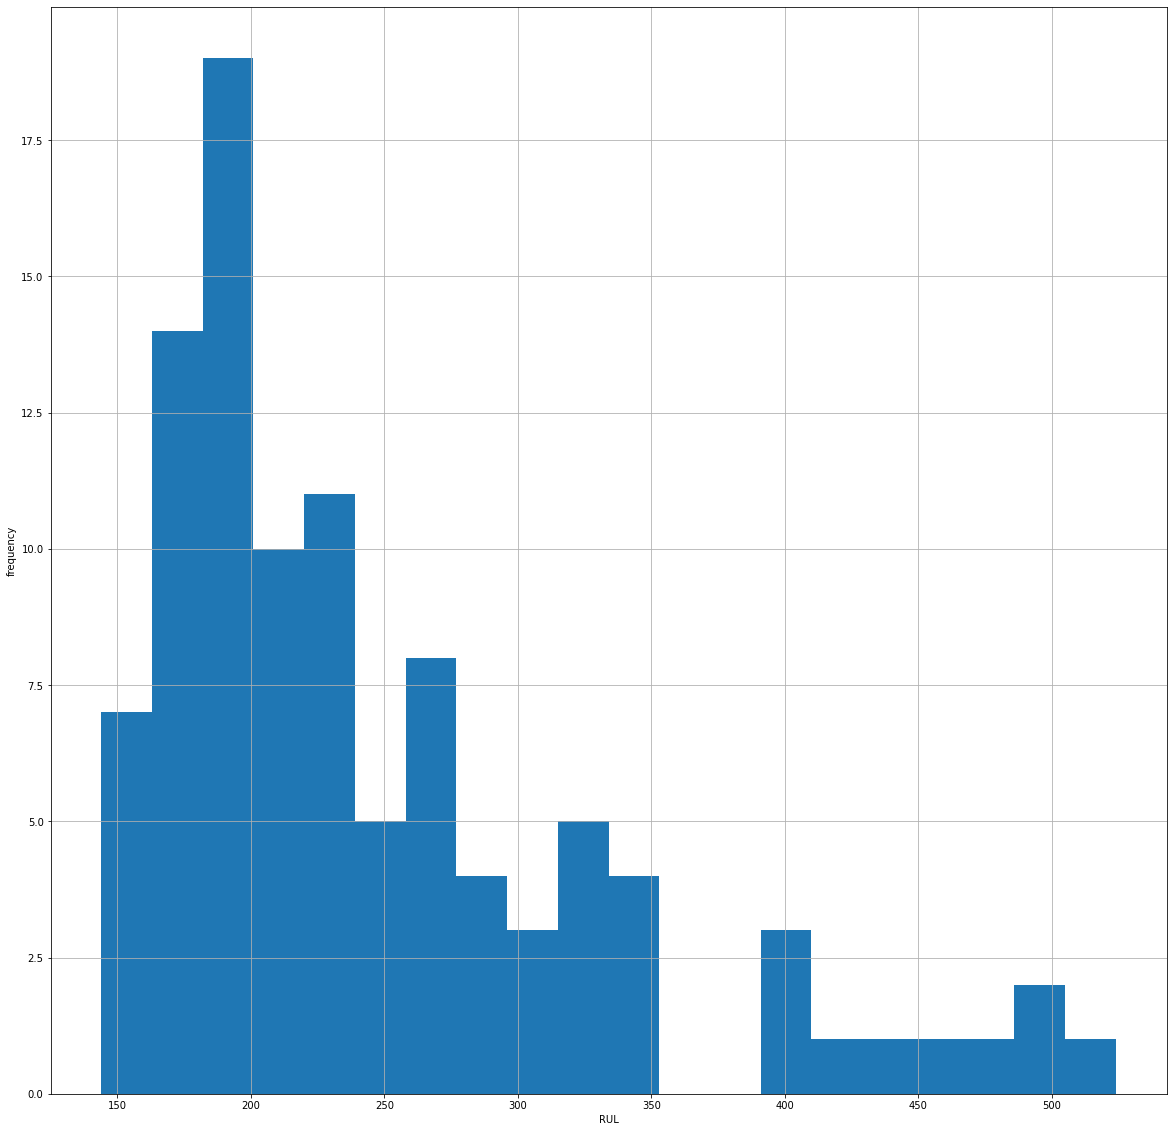

In [ ]:
max_ruls['RUL'].hist(bins=20)
plt.xlabel('RUL')
plt.ylabel('frequency')
print(max_ruls['RUL'].max())

## Предварительный вывод по жизненому циклу
Большинство максимальных значений жизненого цикла прибора лежит в диапазоне 150-250. Если было бы больше данных, мы могли бы сказать с уверенностью, что жизненый цикл прибора не превысит 550 цикло 

In [ ]:
def plot_signal(df, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
        if (i % 10 == 0):  
            plt.plot('RUL', signal_name, 
                     data=df[df['unit_number']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Useful Life')
    plt.show()


def plot_smooth_signal(df, smothed_signal):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
        if i == 10:#(i % 10 == 0):  
            plt.plot(df[df['unit_number']==i]['RUL'], smothed_signal)
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(smothed_signal)
    plt.xlabel('Remaining Useful Life')
    plt.show()

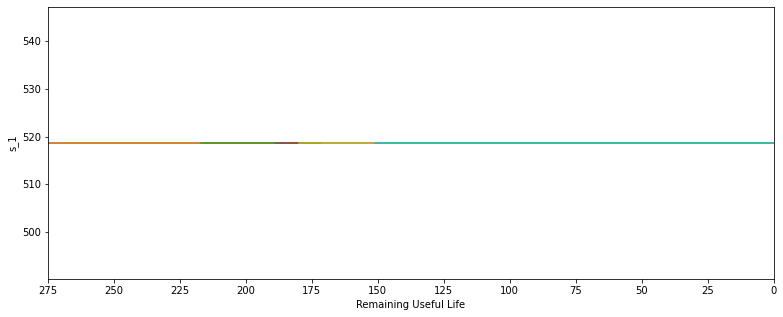

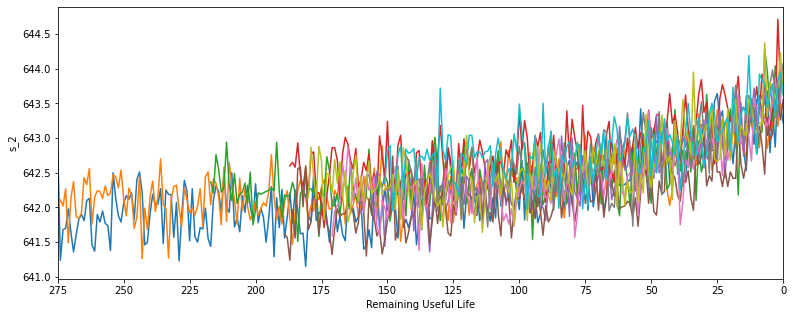

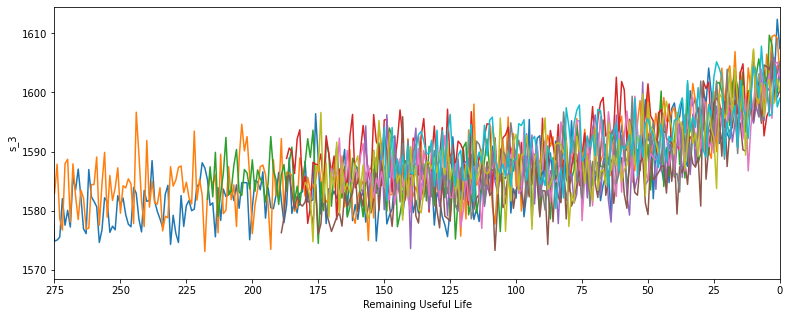

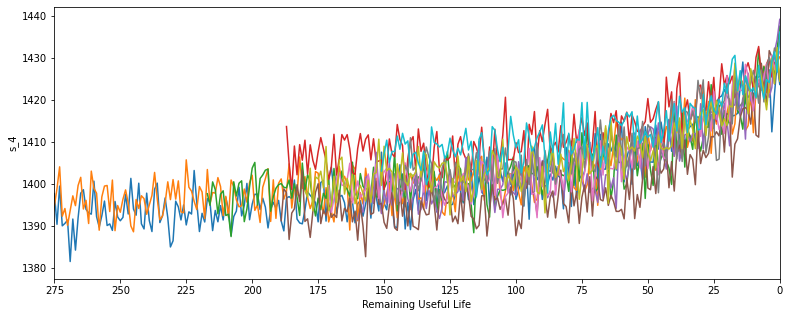

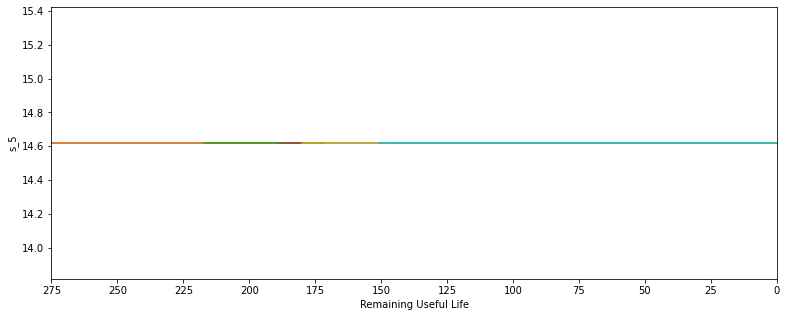

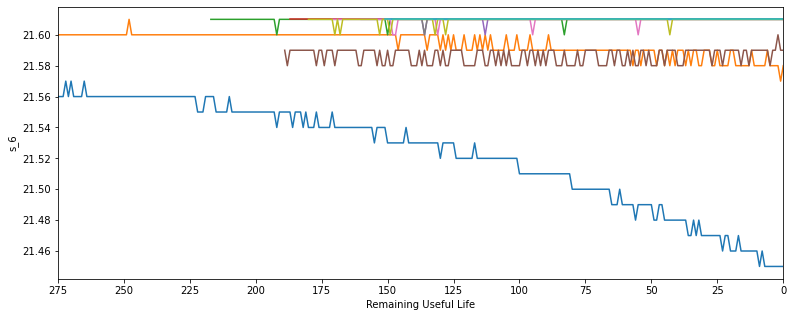

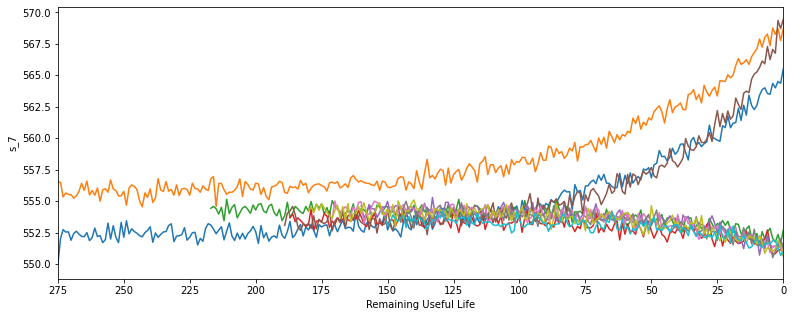

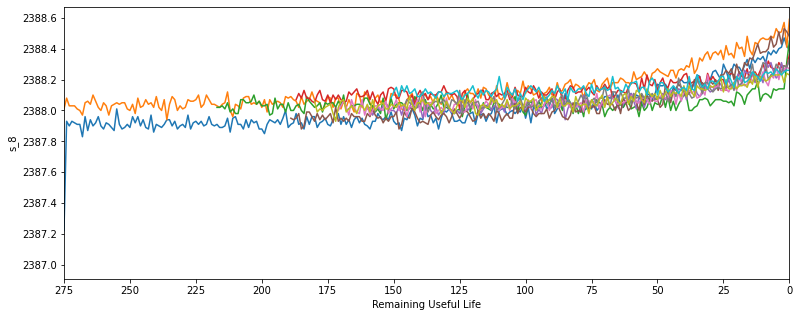

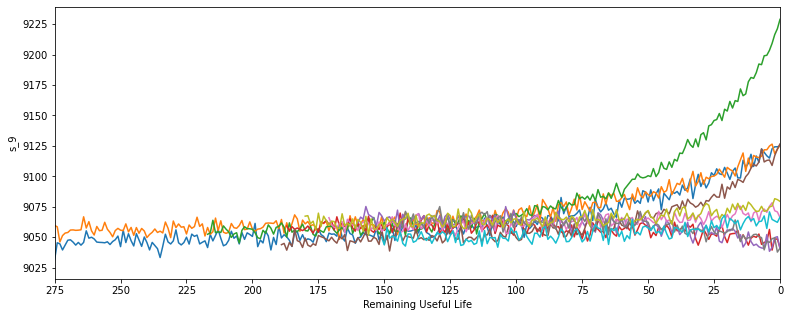

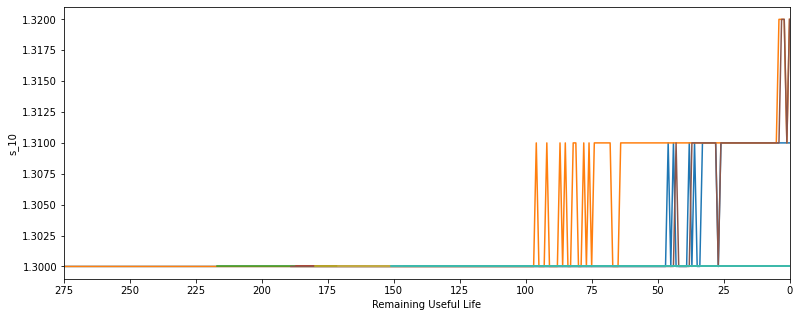

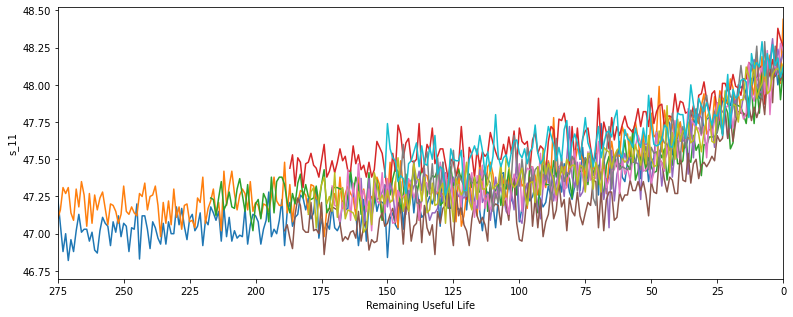

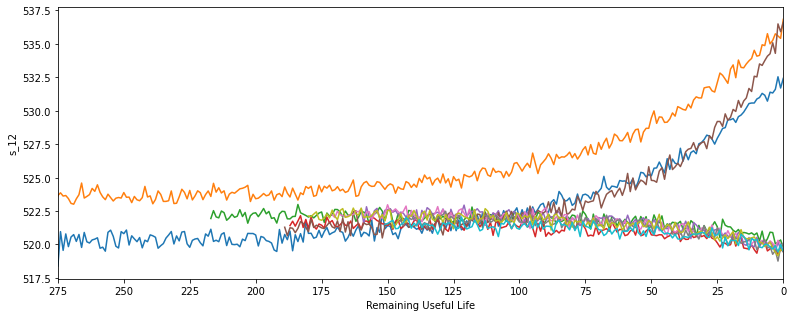

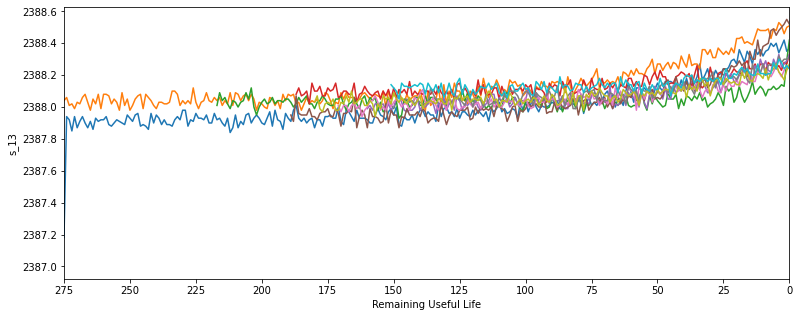

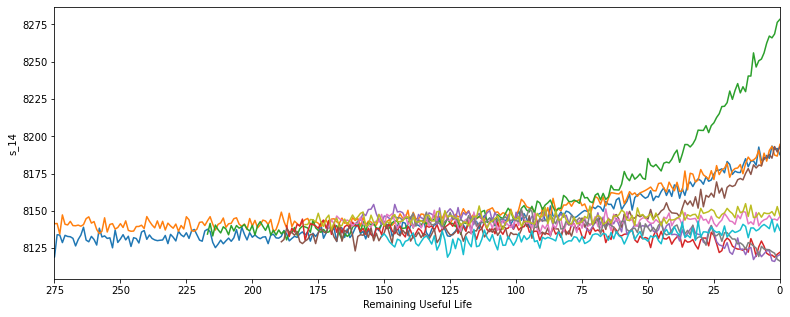

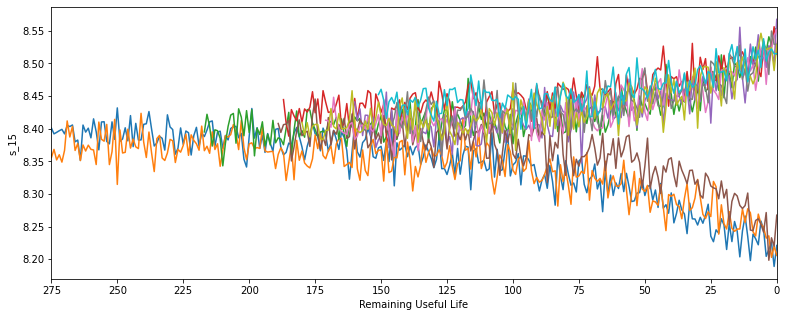

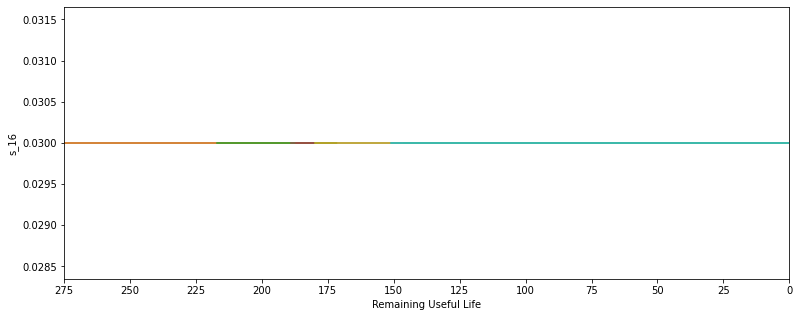

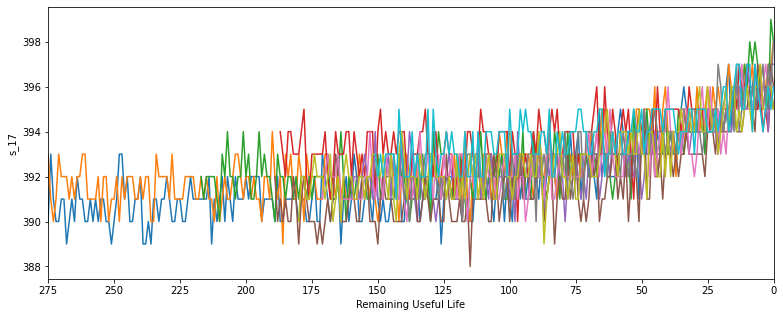

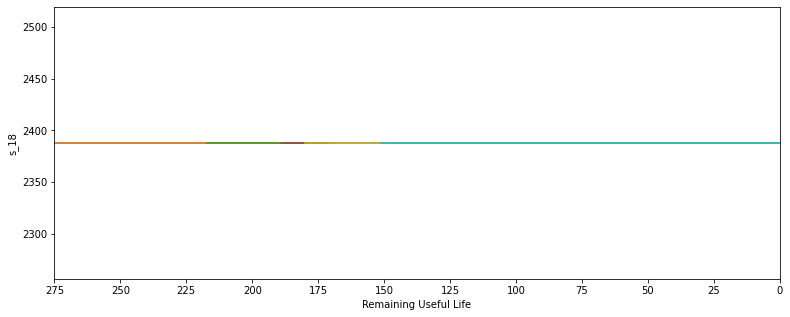

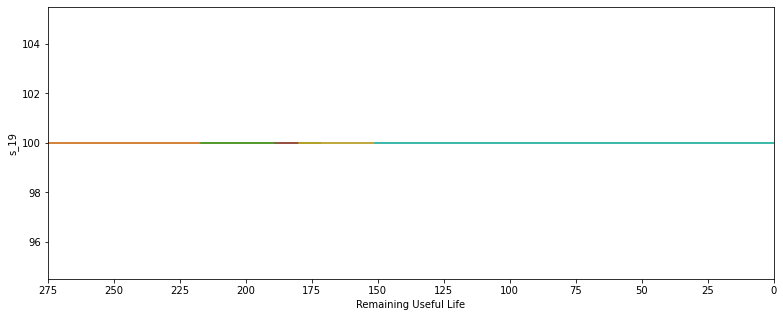

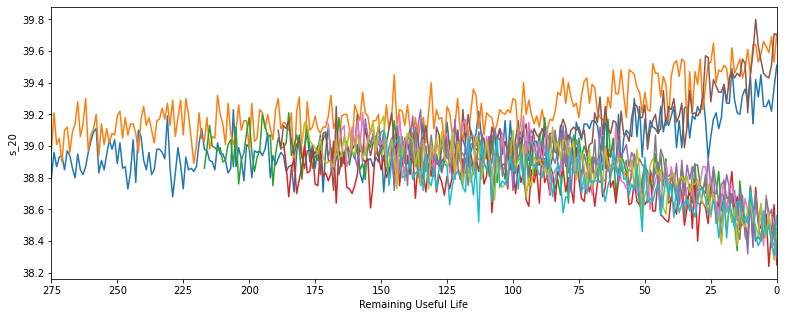

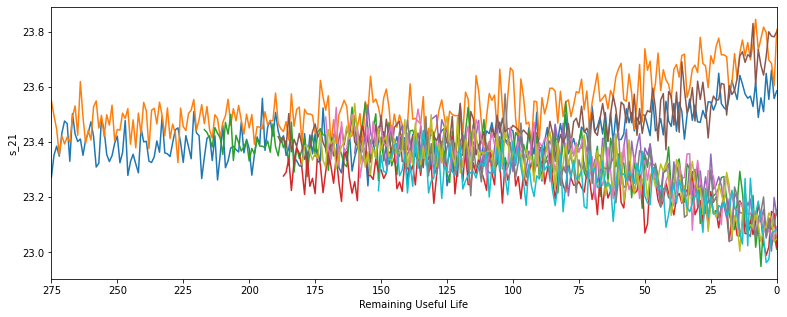

In [ ]:
for sensor in ['s_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
               's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
               's_20', 's_21']:
    try:
        plot_signal(train, sensor)
    except:
        pass

## Краткий анализ датчиков
Из вышеприведенных данных следует, что датчики 1, 5, 16, 18 и 19 не содержат практически никакой информации для определения и прогнозирования жизненого цикла датчика. Они будут удалены перед прогнозированием ниже, чтобы ускорить обучение.

In [ ]:
drop_sensors = ['s_1','s_5','s_16','s_18','s_19']
drop_labels = index_names+setting_names+drop_sensors
remaining_sensors = ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')

X_test = test.groupby('unit_number').last().reset_index().drop(drop_labels, axis=1)

метрика RMSE

In [ ]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

# Обучение алгоритмов
Ниже приведены несколько алгоритмов, на основе деревье, которые используются для определения наилучших результатов на тестовом наборе.

## XGBoost

In [ ]:
xgb = xgboost.XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

# predict and evaluate
y_hat_train = xgb.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test_xgb = xgb.predict(X_test)
evaluate(y_test, y_hat_test_xgb)

[12:18:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train set RMSE:55.49170328053446, R2:0.6848266081089511
test set RMSE:48.233583255220445, R2:-0.3576574533240955


## Catboost

In [ ]:
catb = catboost.CatBoostRegressor(verbose=False, random_state=42)
catb.fit(X_train, y_train)

# predict and evaluate
y_hat_train = catb.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test_catb = catb.predict(X_test)
evaluate(y_test, y_hat_test_catb)

train set RMSE:45.28246761800389, R2:0.7901284329585707
test set RMSE:48.7627007103778, R2:-0.38760755767274624


## RandomForest

In [ ]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)
rf.fit(X_train, y_train)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test_rf = rf.predict(X_test)
evaluate(y_test, y_hat_test_rf)

train set RMSE:21.025240351169202, R2:0.9547545019533699
test set RMSE:46.358798830427006, R2:-0.254167389706895


# Визуализация результатов




In [ ]:
def plot_results(y_test, y_hat_test):
    width = 0.8

    actuals = [int(x) for x in y_test.values]
    predictions = list(y_hat_test)

    indices = np.arange(len(y_hat_test))

    plt.figure(figsize=(60,20))

    plt.bar(indices, actuals, width=width, 
            color='b', label='Actual RUL')
    plt.bar([i for i in indices], predictions, 
            width=0.5*width, color='r', alpha=0.7, label='Predicted RUL')

    plt.legend(prop={'size': 30})
    plt.tick_params(labelsize=30)

    plt.show()


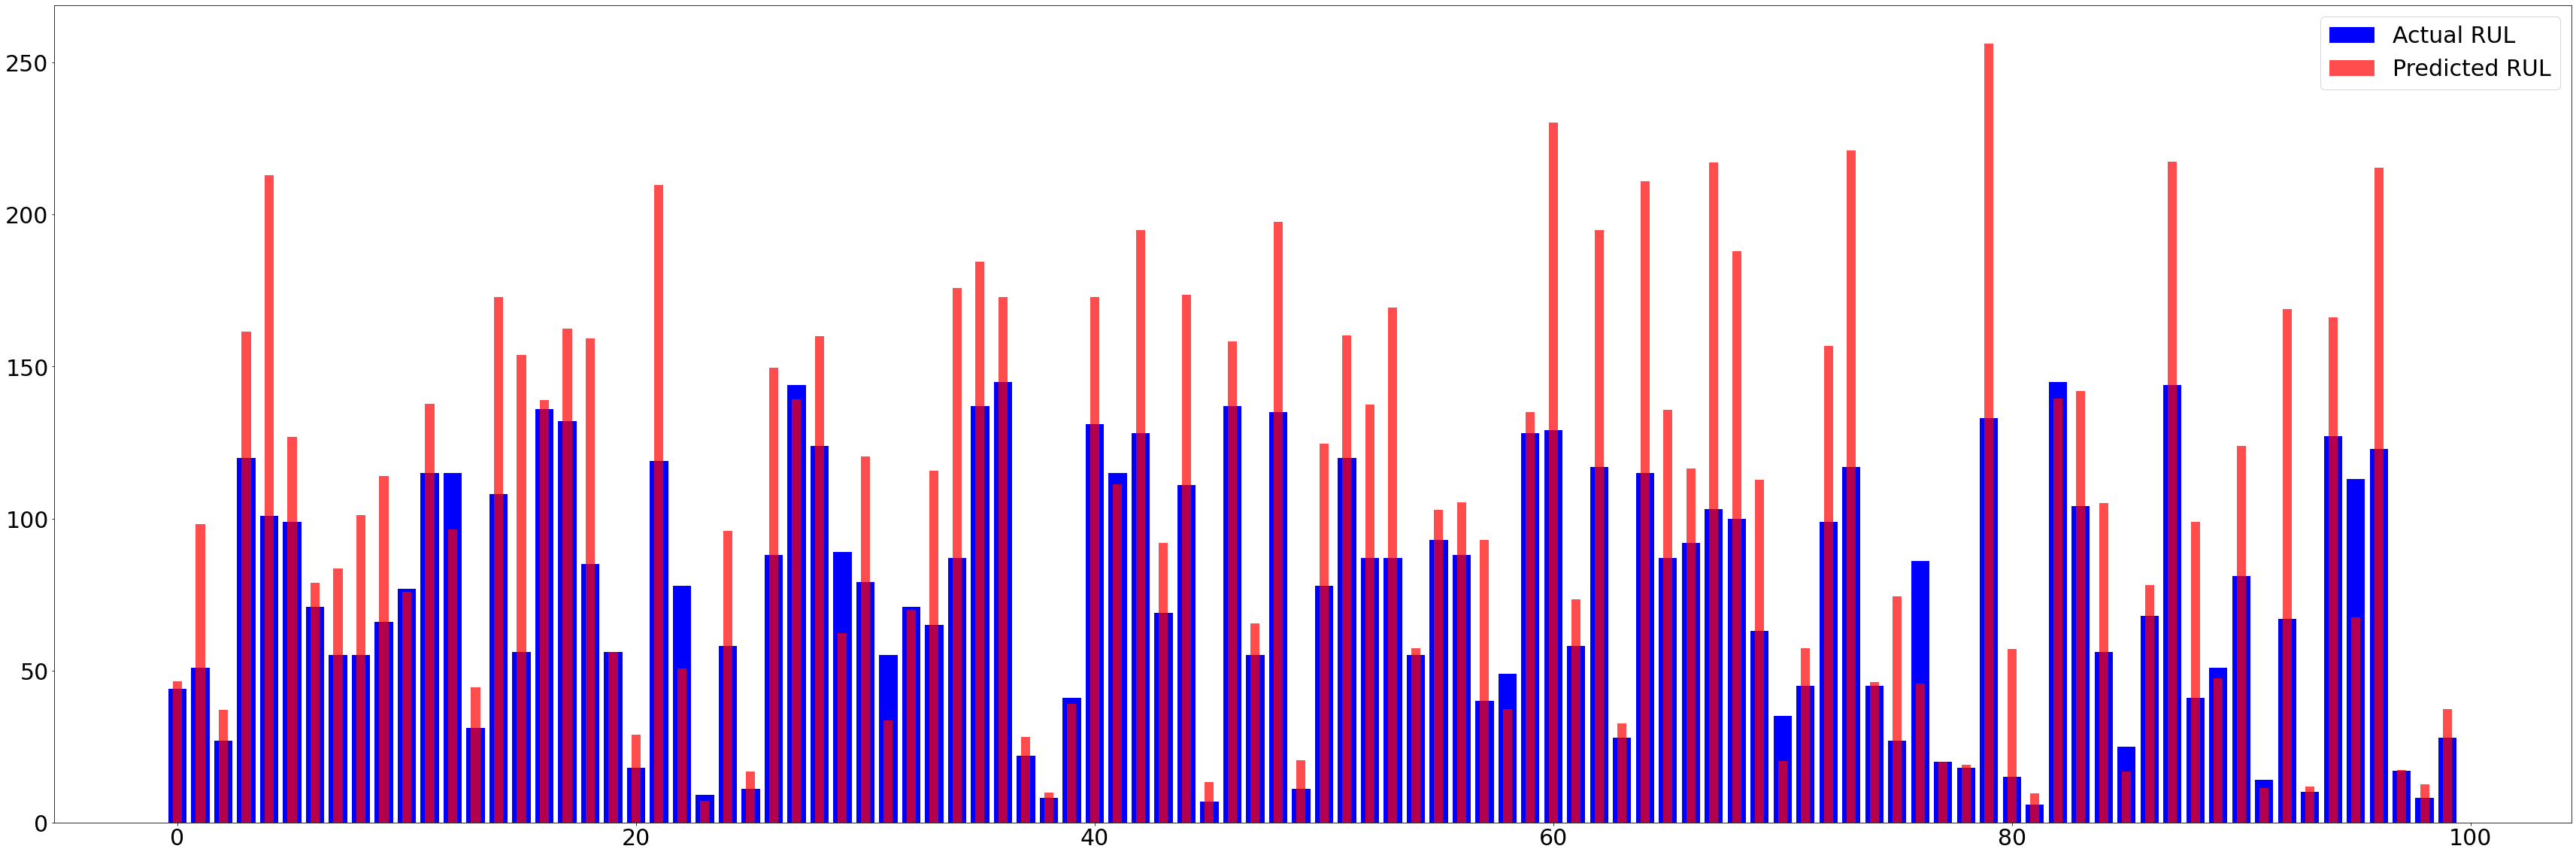

In [ ]:
plot_results(y_test, y_hat_test_xgb)

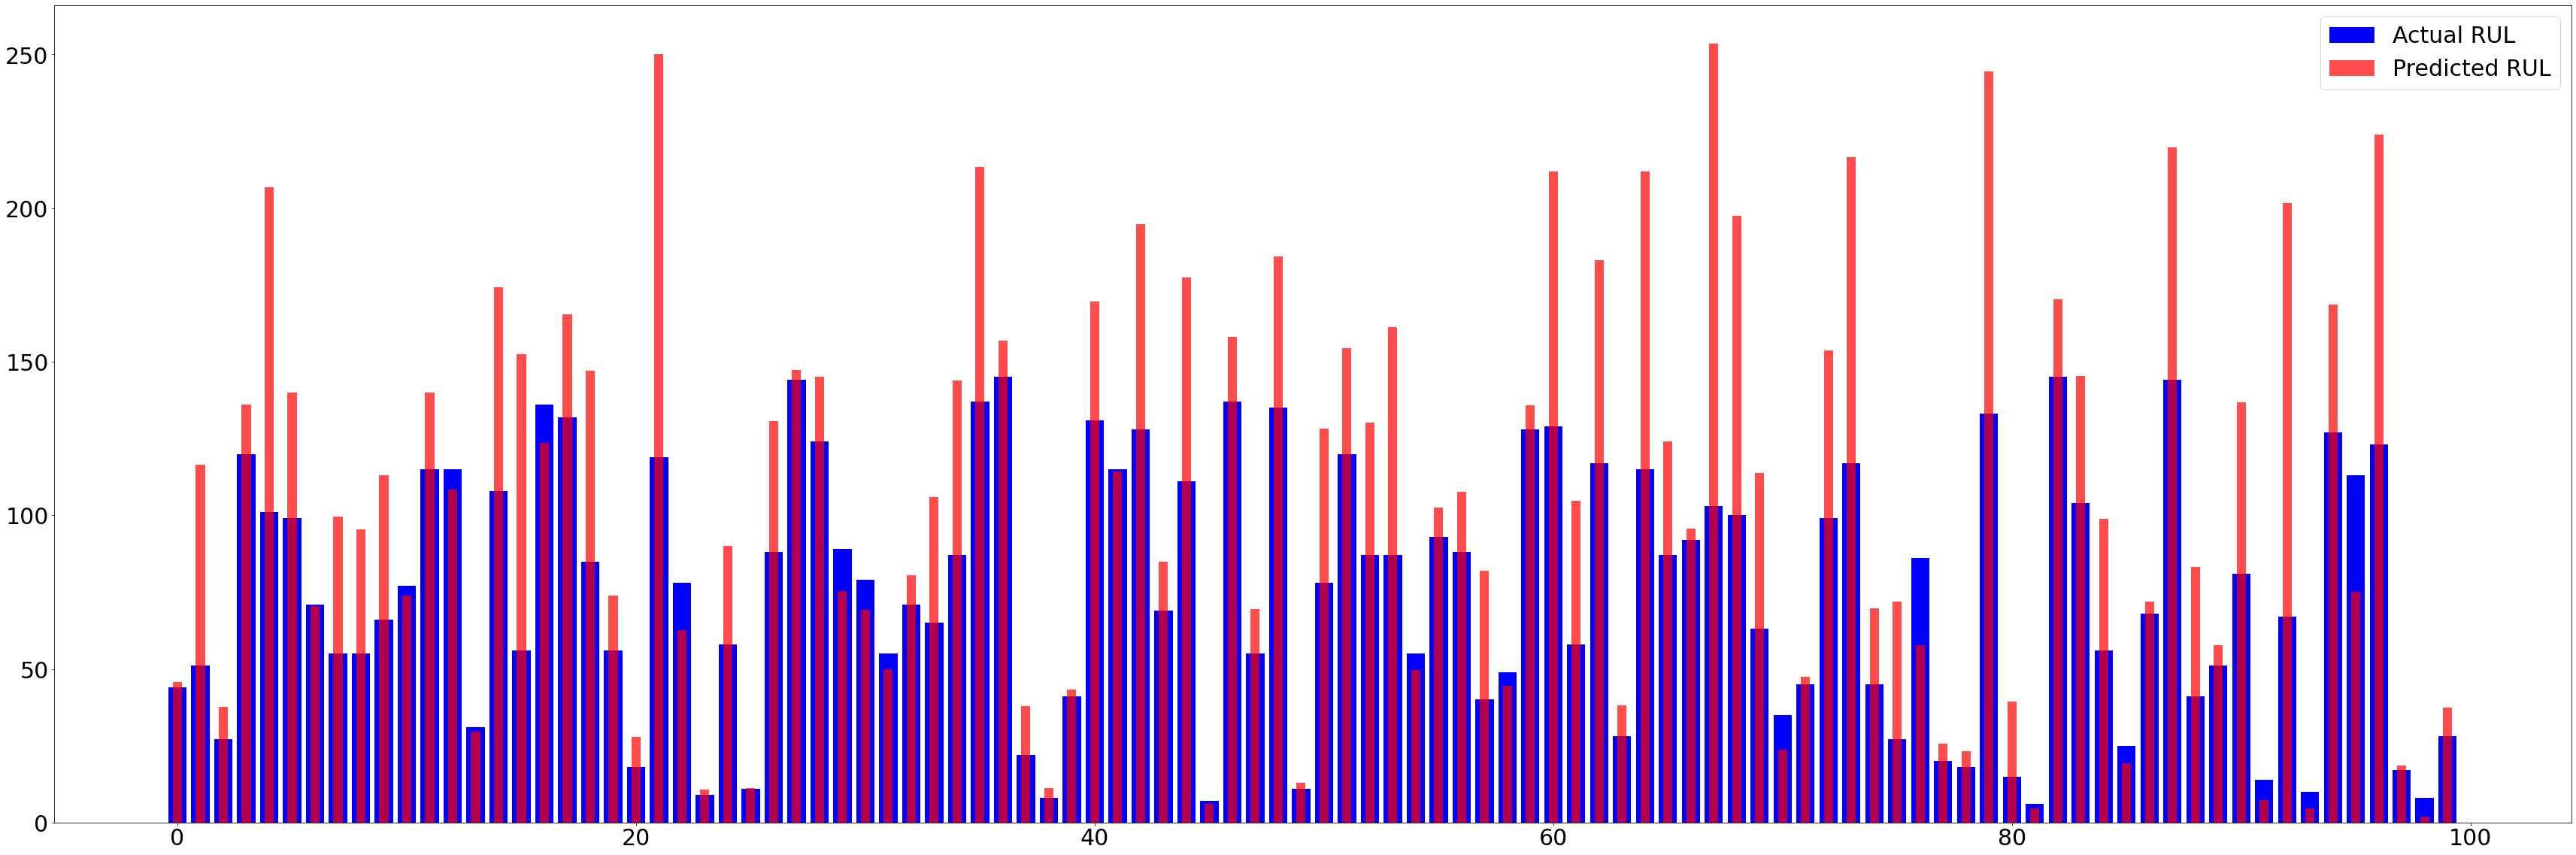

In [ ]:
plot_results(y_test, y_hat_test_catb)

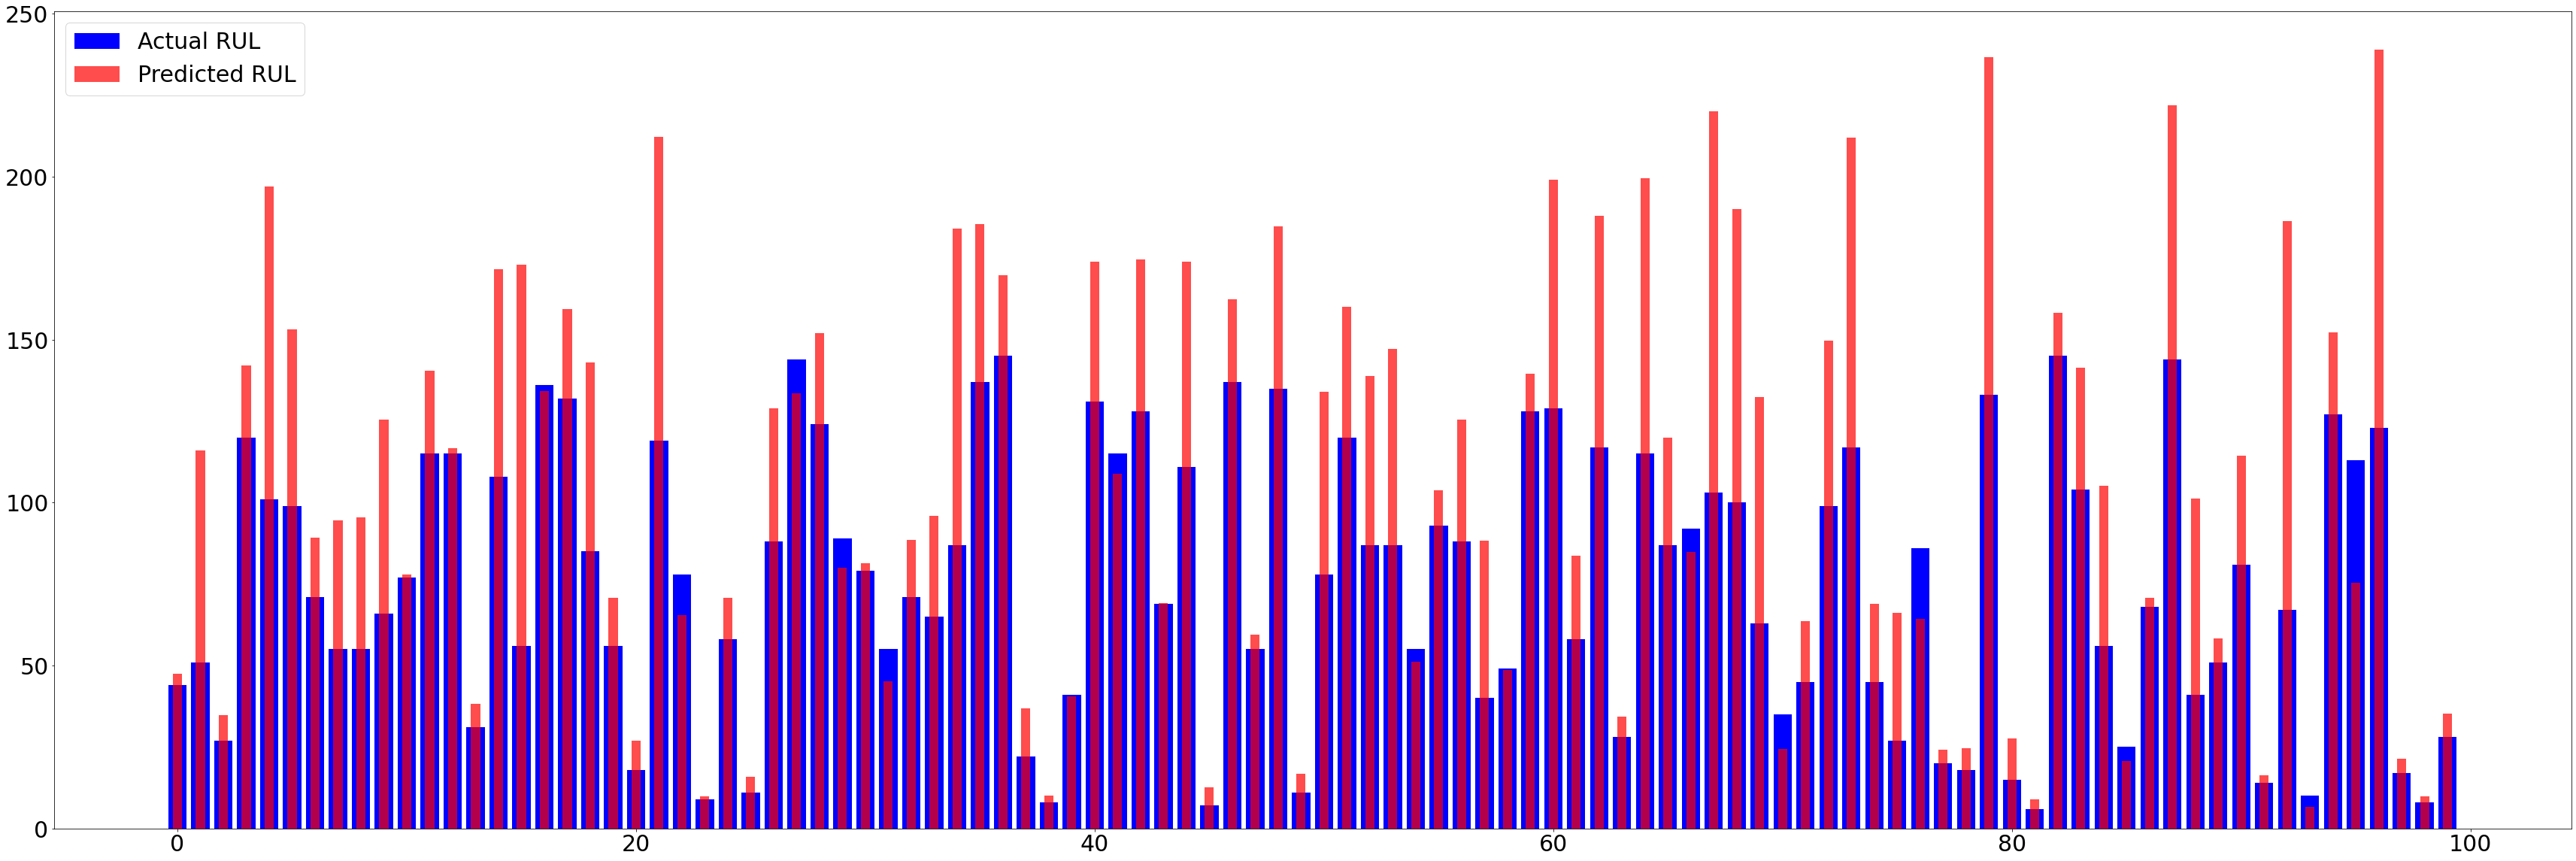

In [ ]:
plot_results(y_test, y_hat_test_rf)

# Ограничим значение RUL
Сделаем максимальное значение RUL равным 115


In [ ]:
drop_sensors = ['s_1','s_5','s_16','s_18','s_19']
drop_labels = index_names+setting_names+drop_sensors
remaining_sensors = ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')
y_train_clipped = y_train.clip(upper=115)  # apply RUL clipping

X_test = test.groupby('unit_number').last().reset_index().drop(drop_labels, axis=1)

## Запустим еще раз

In [ ]:
xgb = xgboost.XGBRegressor(random_state=42)
xgb.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = xgb.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test_xgb_clip = xgb.predict(X_test)
evaluate(y_test, y_hat_test_xgb_clip)

[12:24:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train set RMSE:93.37521318991541, R2:0.1076059877904545
test set RMSE:20.79972919401223, R2:0.7475318974861749


In [ ]:
catb = catboost.CatBoostRegressor(verbose=False, random_state=42)
catb.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = catb.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test_catb_clip = catb.predict(X_test)
evaluate(y_test, y_hat_test_catb_clip)

train set RMSE:92.6803910827589, R2:0.12083751026822254
test set RMSE:20.263677460339203, R2:0.7603774513826006


In [ ]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test_rf_clip = rf.predict(X_test)
evaluate(y_test, y_hat_test_rf_clip)

train set RMSE:5.158896101752112, R2:0.9802797863716584
test set RMSE:20.225672522811198, R2:0.7612754423792377


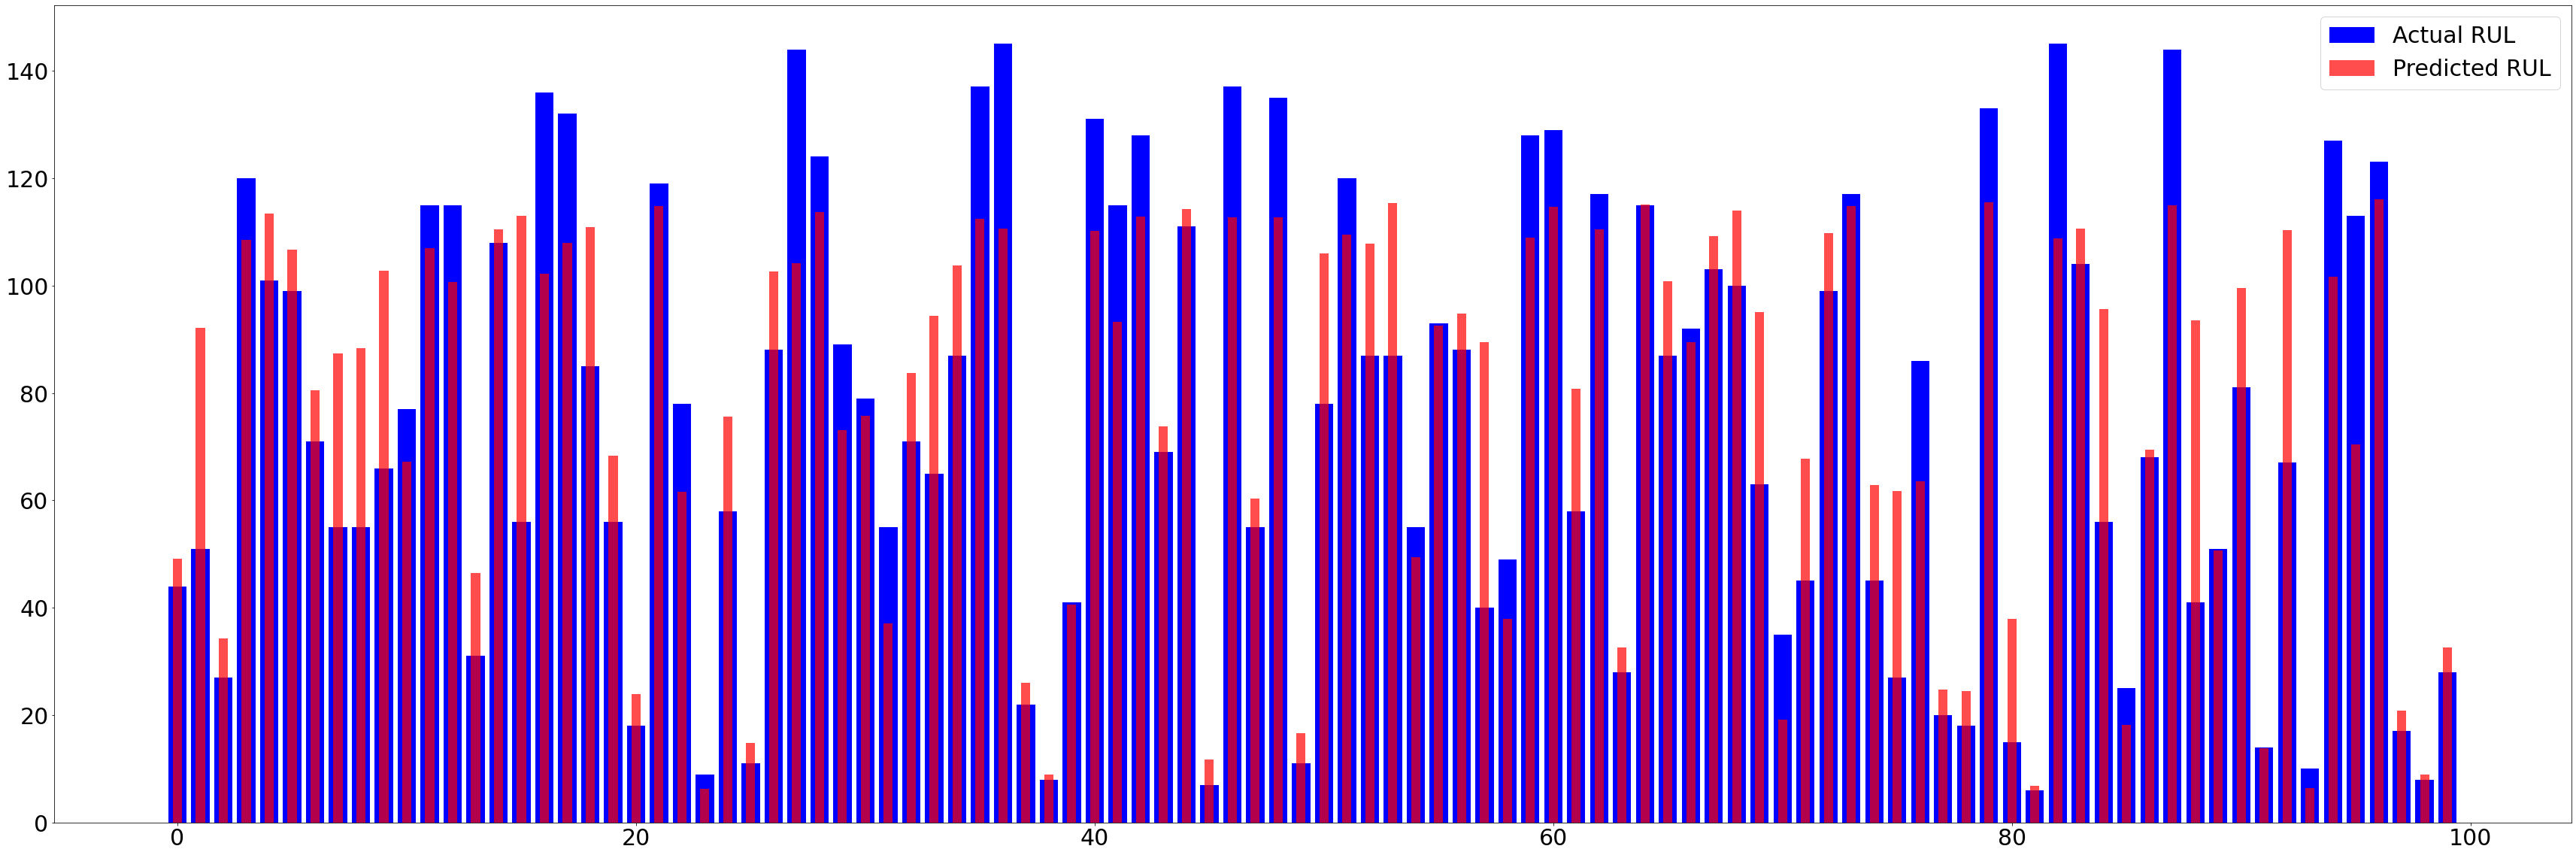

In [ ]:
plot_results(y_test, y_hat_test_xgb_clip)

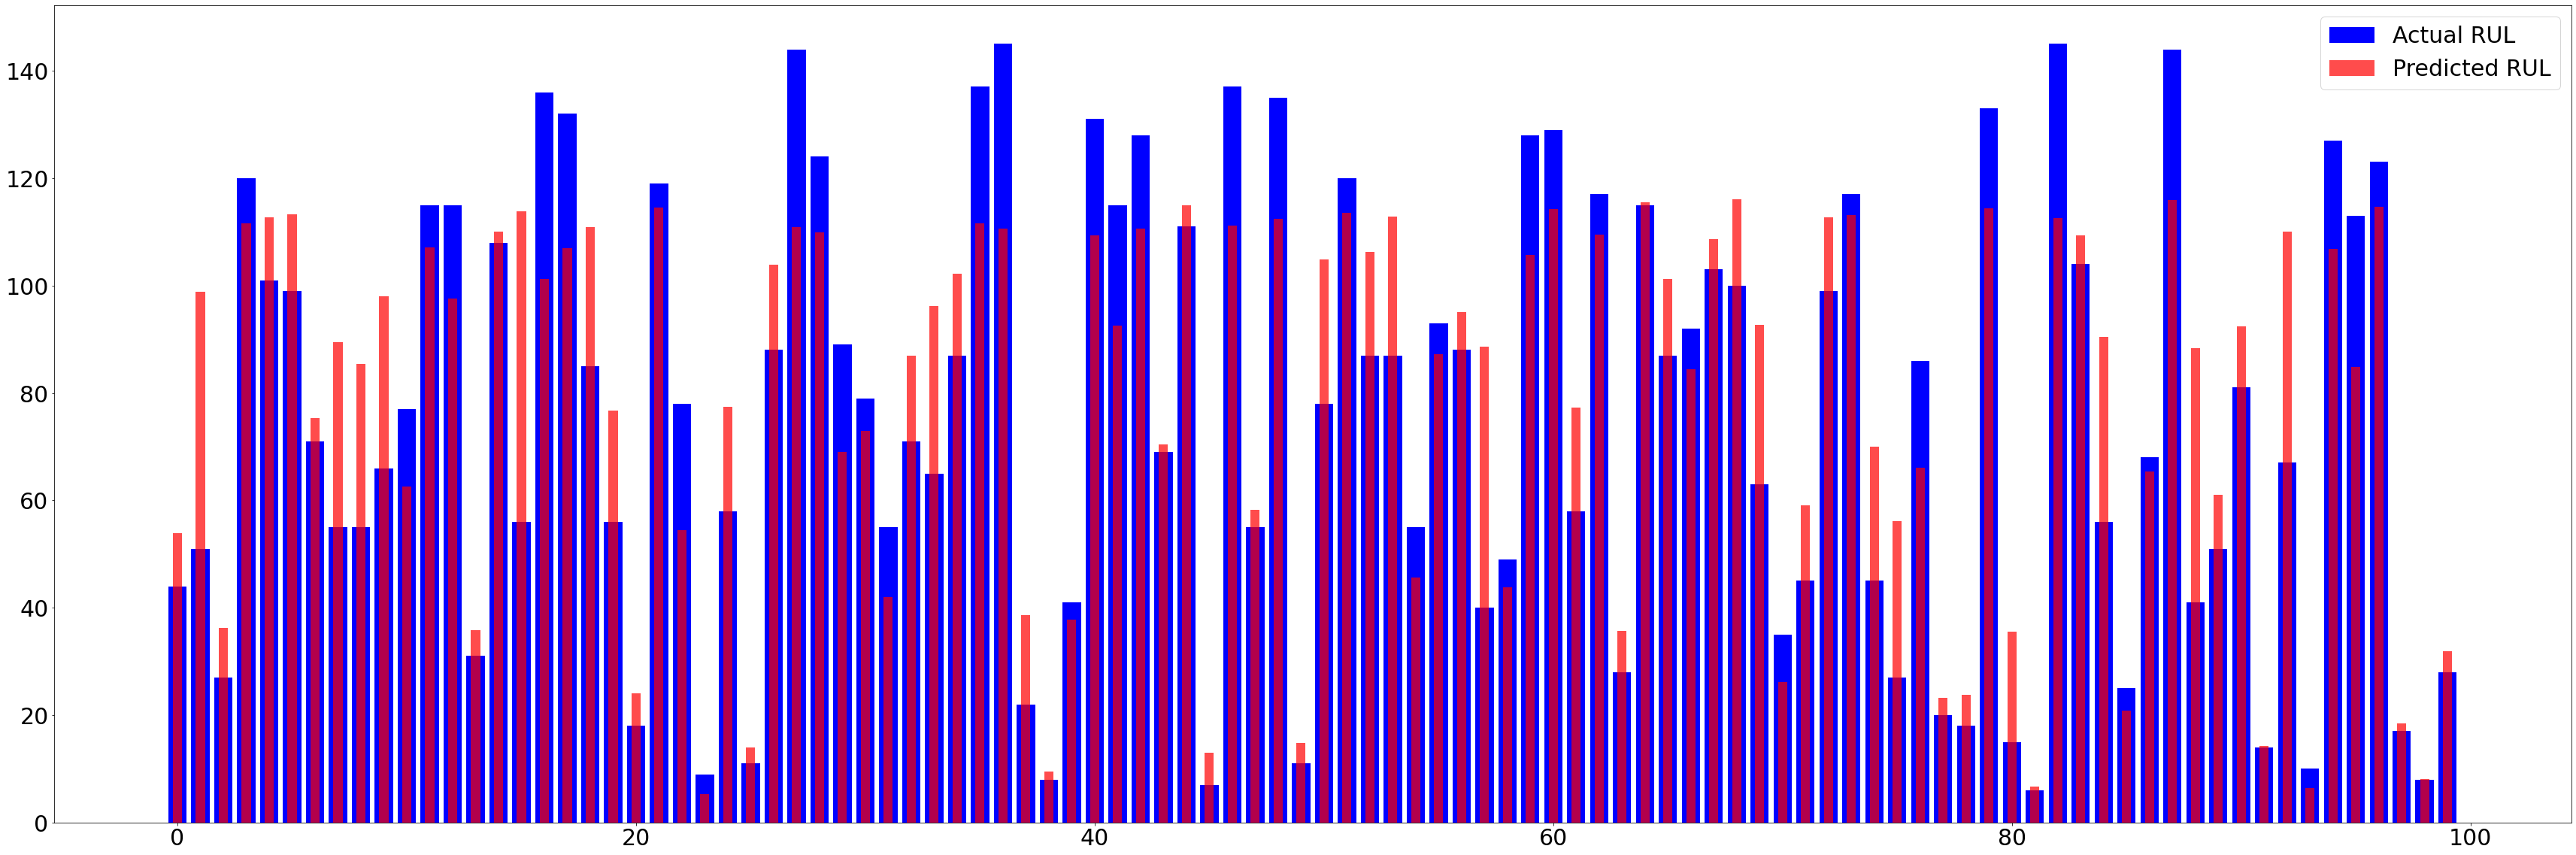

In [ ]:
plot_results(y_test, y_hat_test_catb_clip)

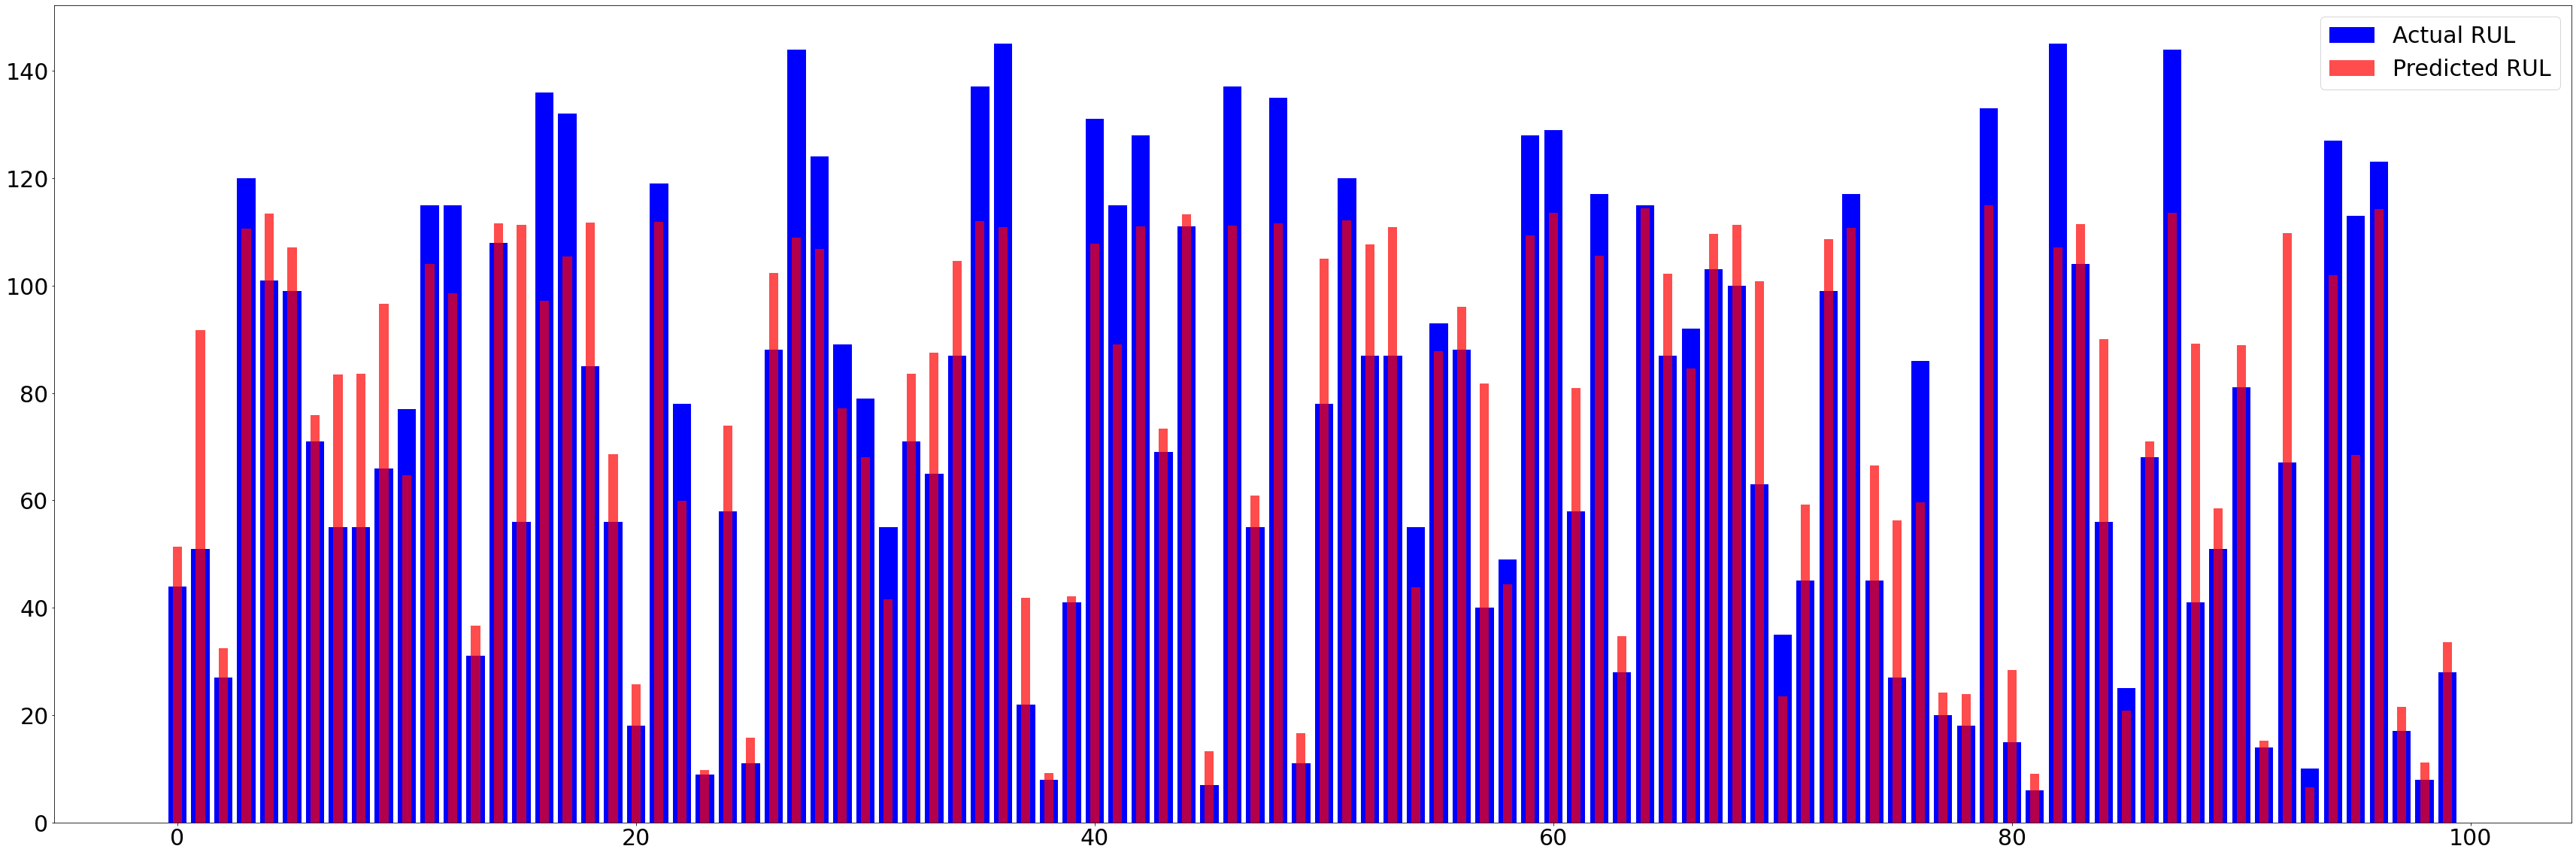

In [ ]:
plot_results(y_test, y_hat_test_rf_clip)

Видим качественные улучшения 

# Сглаживание сигналов
Визуализируя сигналы, видим, что сигналы шумные. Чтобы улучшить результаты прогнозирования, можно попытаться удалить часть шума. Для удаления шума мы можем использовать различные фильтры, например фильтр Savitzky-Golay. Он в основном подходит для регрессии к подмножествам данных и имеет возможность дифференцировать данные. Он неплохо работает в данном конкретном случае.

In [ ]:
def apply_filter(df, filter):
    for unit in df['unit_number'].unique():
        for sensor in df.loc[:,'s_1':]:
            if sensor != 'RUL':
    
                df.loc[df['unit_number']==unit, sensor] = filter(df.loc[df['unit_number']==unit, sensor],
                                                                              window_length=19, 
                                                                              polyorder=1,
                                                                              deriv=0,
                                                                              mode='interp') 
    return df

# Применение фильтра
После быстрого тестирования наилучшие результаты были достигнуты при применении фильтра к данным 3 раза.

In [ ]:
train = apply_filter(train, ss.savgol_filter)
train = apply_filter(train, ss.savgol_filter)
train = apply_filter(train, ss.savgol_filter)

In [ ]:
test = apply_filter(test, ss.savgol_filter)
test = apply_filter(test, ss.savgol_filter)
test = apply_filter(test, ss.savgol_filter)

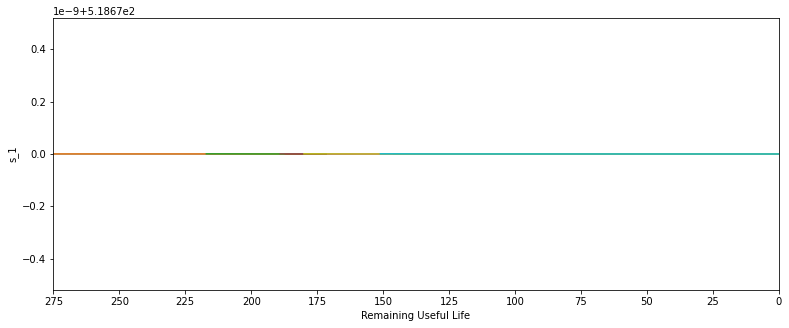

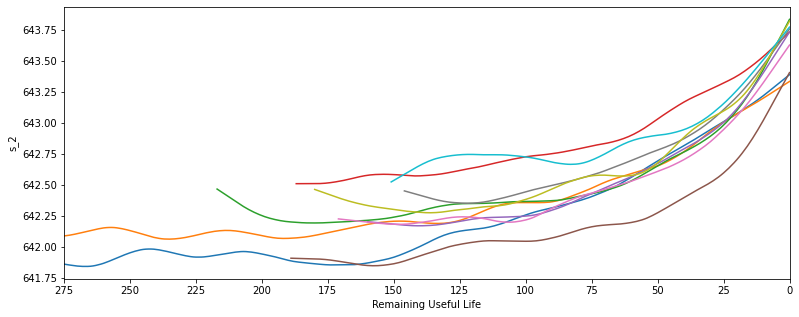

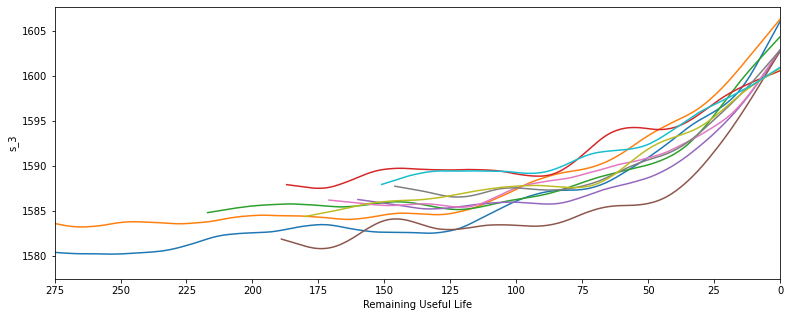

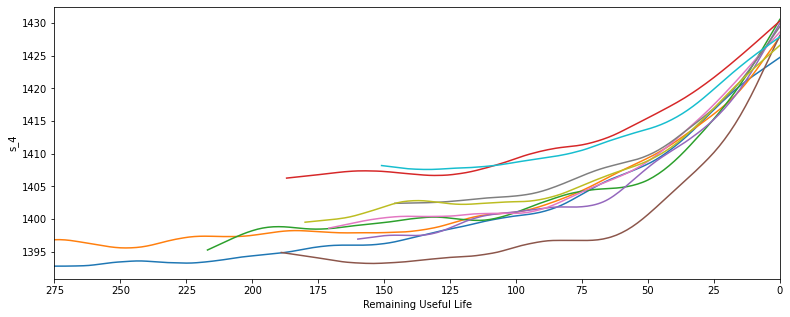

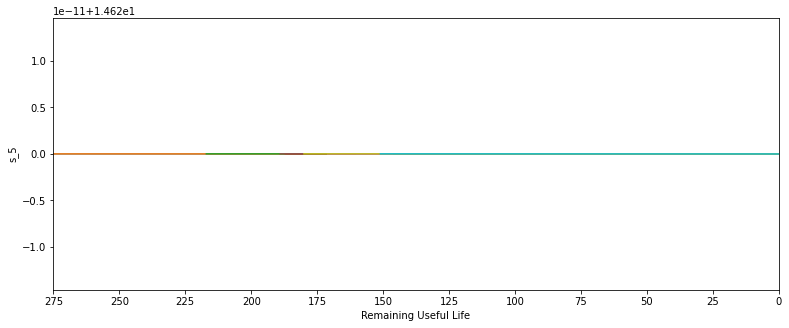

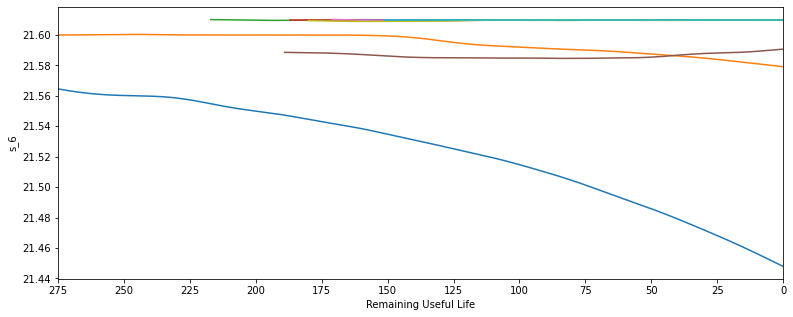

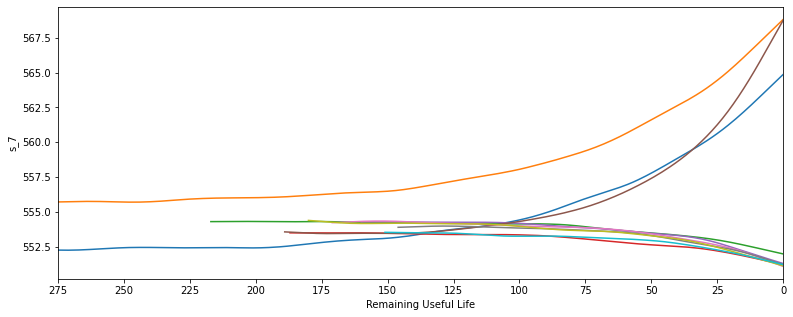

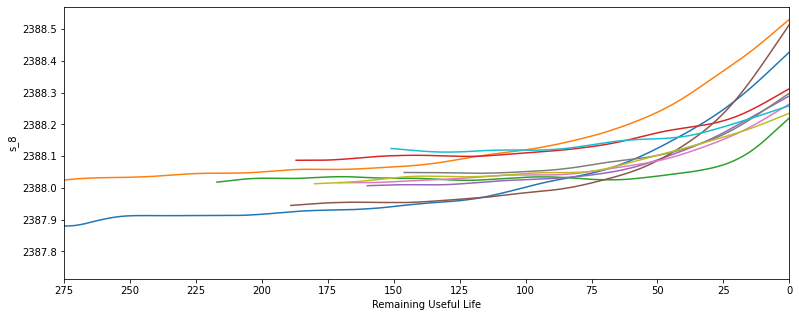

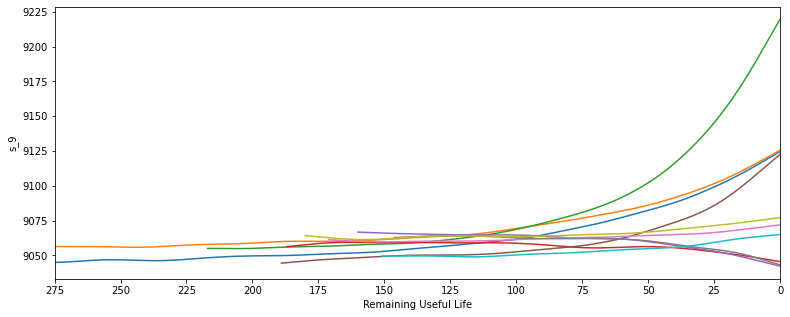

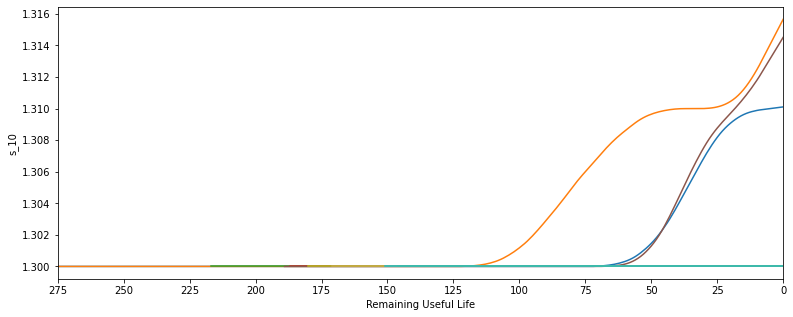

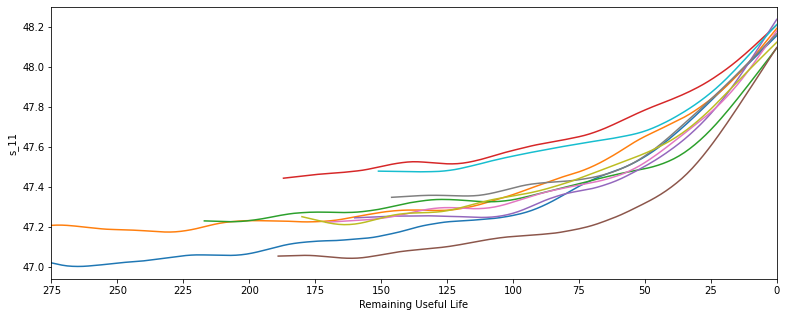

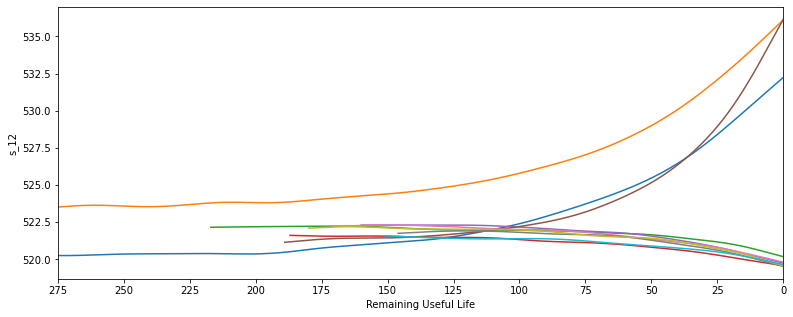

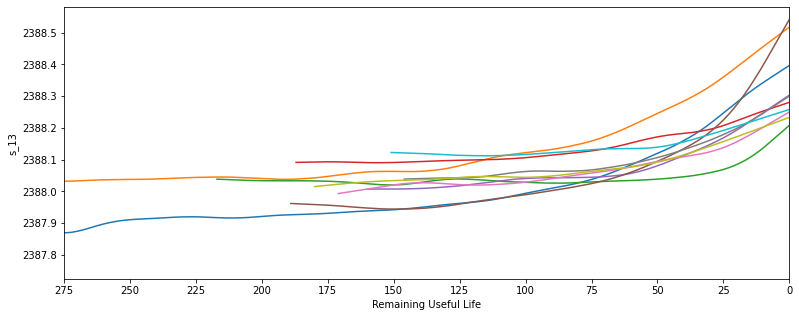

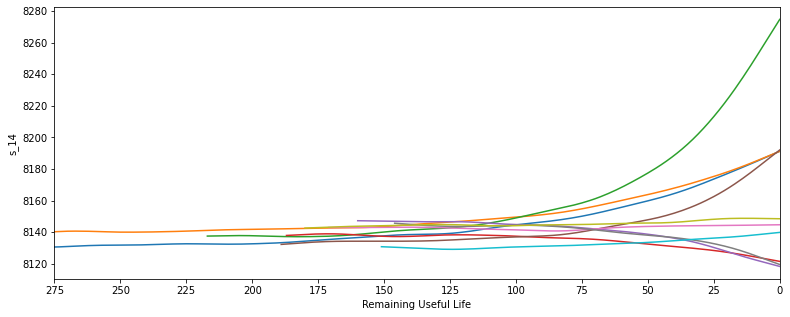

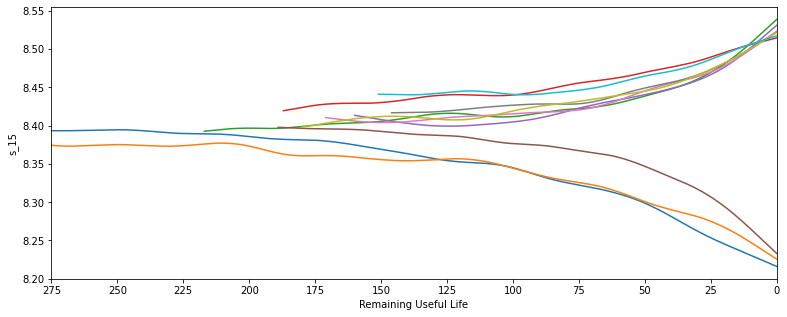

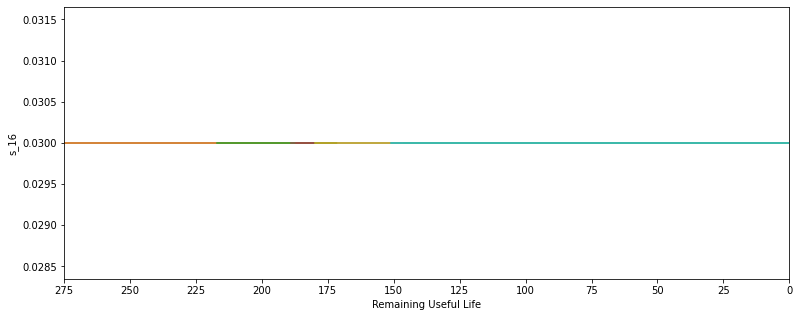

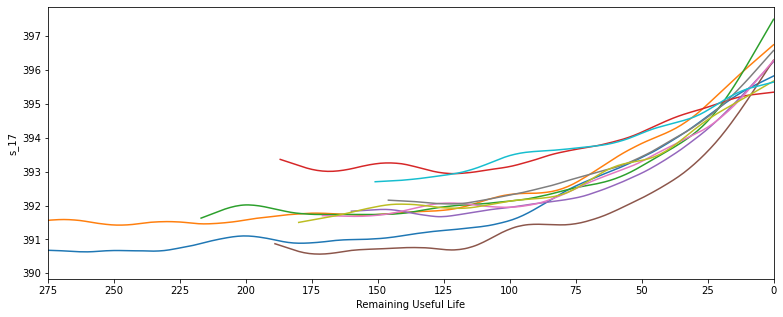

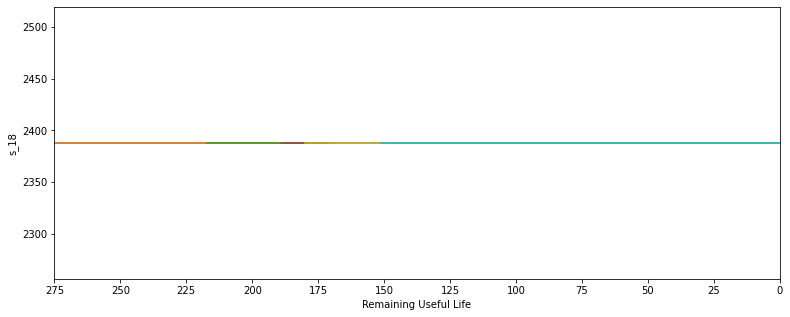

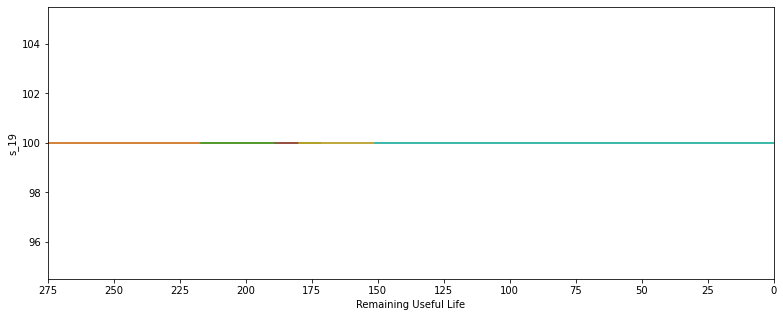

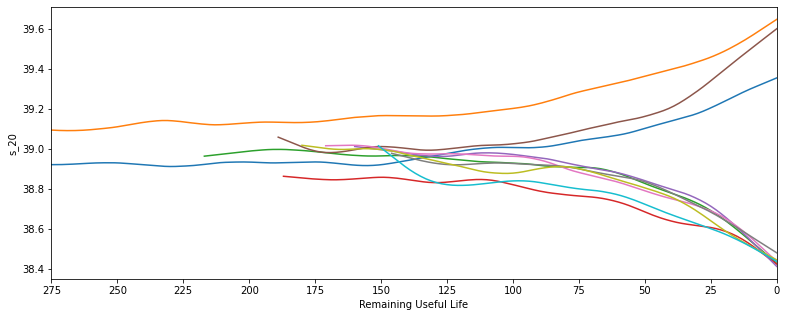

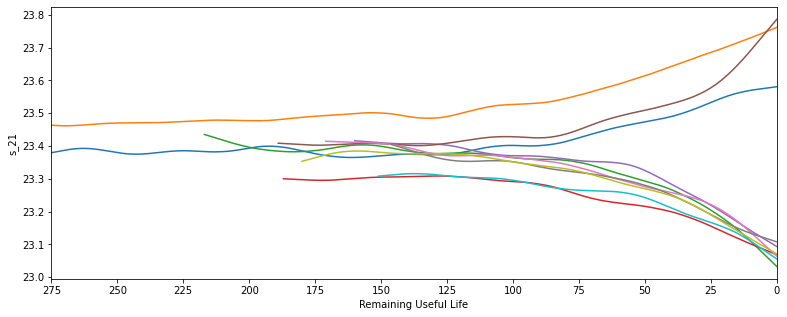

In [ ]:
for sensor in ['s_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
               's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
               's_20', 's_21']:
    try:
        plot_signal(train, sensor)
    except:
        pass

In [ ]:
drop_sensors = ['s_1','s_5','s_16','s_18','s_19']
drop_labels = index_names+setting_names+drop_sensors
remaining_sensors = ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')
y_train_clipped = y_train.clip(upper=115) 

# Поскольку истинные значения RUL для тестового набора предоставляются только для 
# последнего временного цикла каждого двигателя, тестовый набор подразделяется на подмножества, 
# чтобы отразить одно и то же.
X_test = test.groupby('unit_number').last().reset_index().drop(drop_labels, axis=1)

In [ ]:
xgb = xgboost.XGBRegressor(random_state=42)
xgb.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = xgb.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test_xgb_clip = xgb.predict(X_test)
evaluate(y_test, y_hat_test_xgb_clip)

[12:43:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train set RMSE:92.39178244013782, R2:0.1263044450441052
test set RMSE:20.935380598785656, R2:0.7442280726723643


In [ ]:
catb = catboost.CatBoostRegressor(verbose=False, random_state=42)
catb.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = catb.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test_catb_clip = catb.predict(X_test)
evaluate(y_test, y_hat_test_catb_clip)

train set RMSE:91.19956098937261, R2:0.14870725868154233
test set RMSE:20.196272643230362, R2:0.7619689542750905


In [ ]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)
rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test_rf_clip = rf.predict(X_test)
evaluate(y_test, y_hat_test_rf_clip)

train set RMSE:1.5424702086783375, R2:0.9982370839890721
test set RMSE:19.558040955065003, R2:0.776775500852709


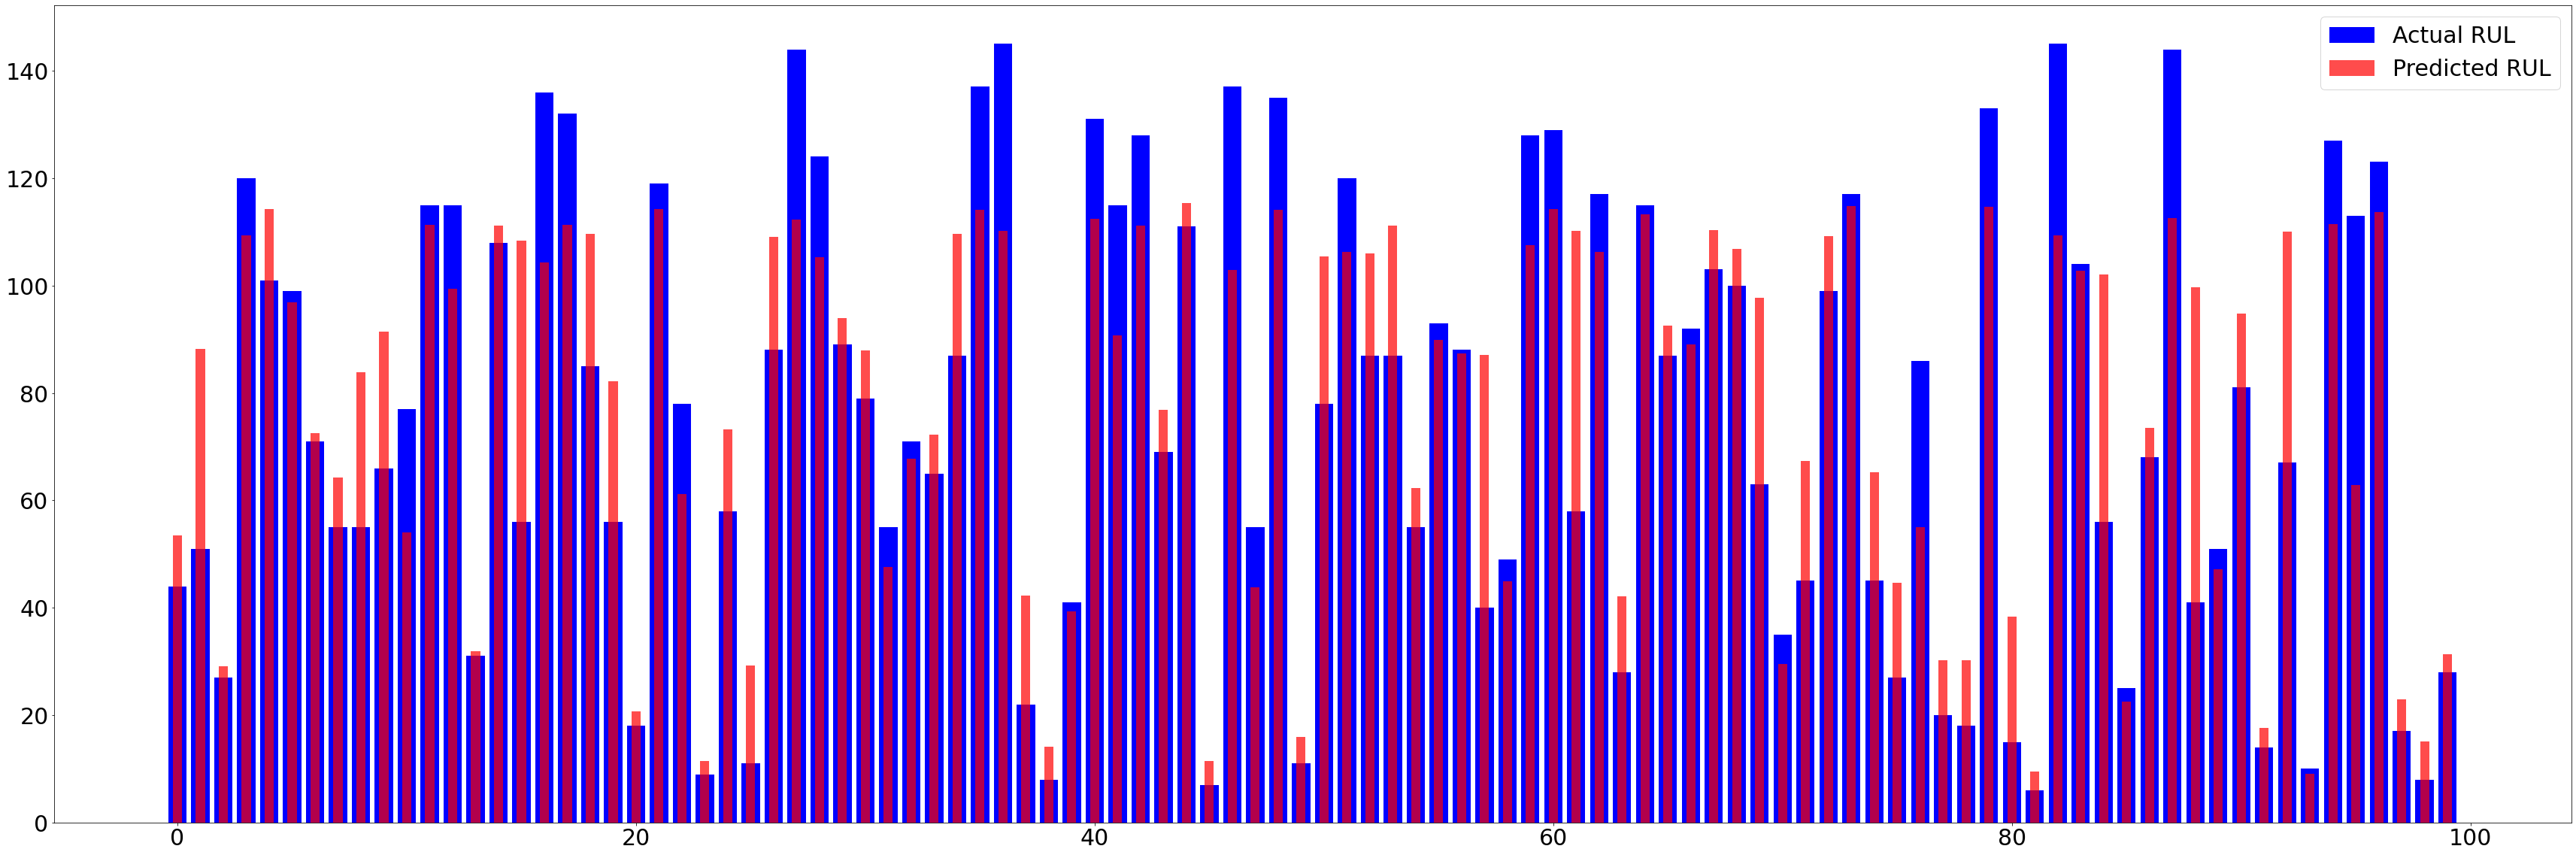

In [ ]:
plot_results(y_test, y_hat_test_xgb_clip)

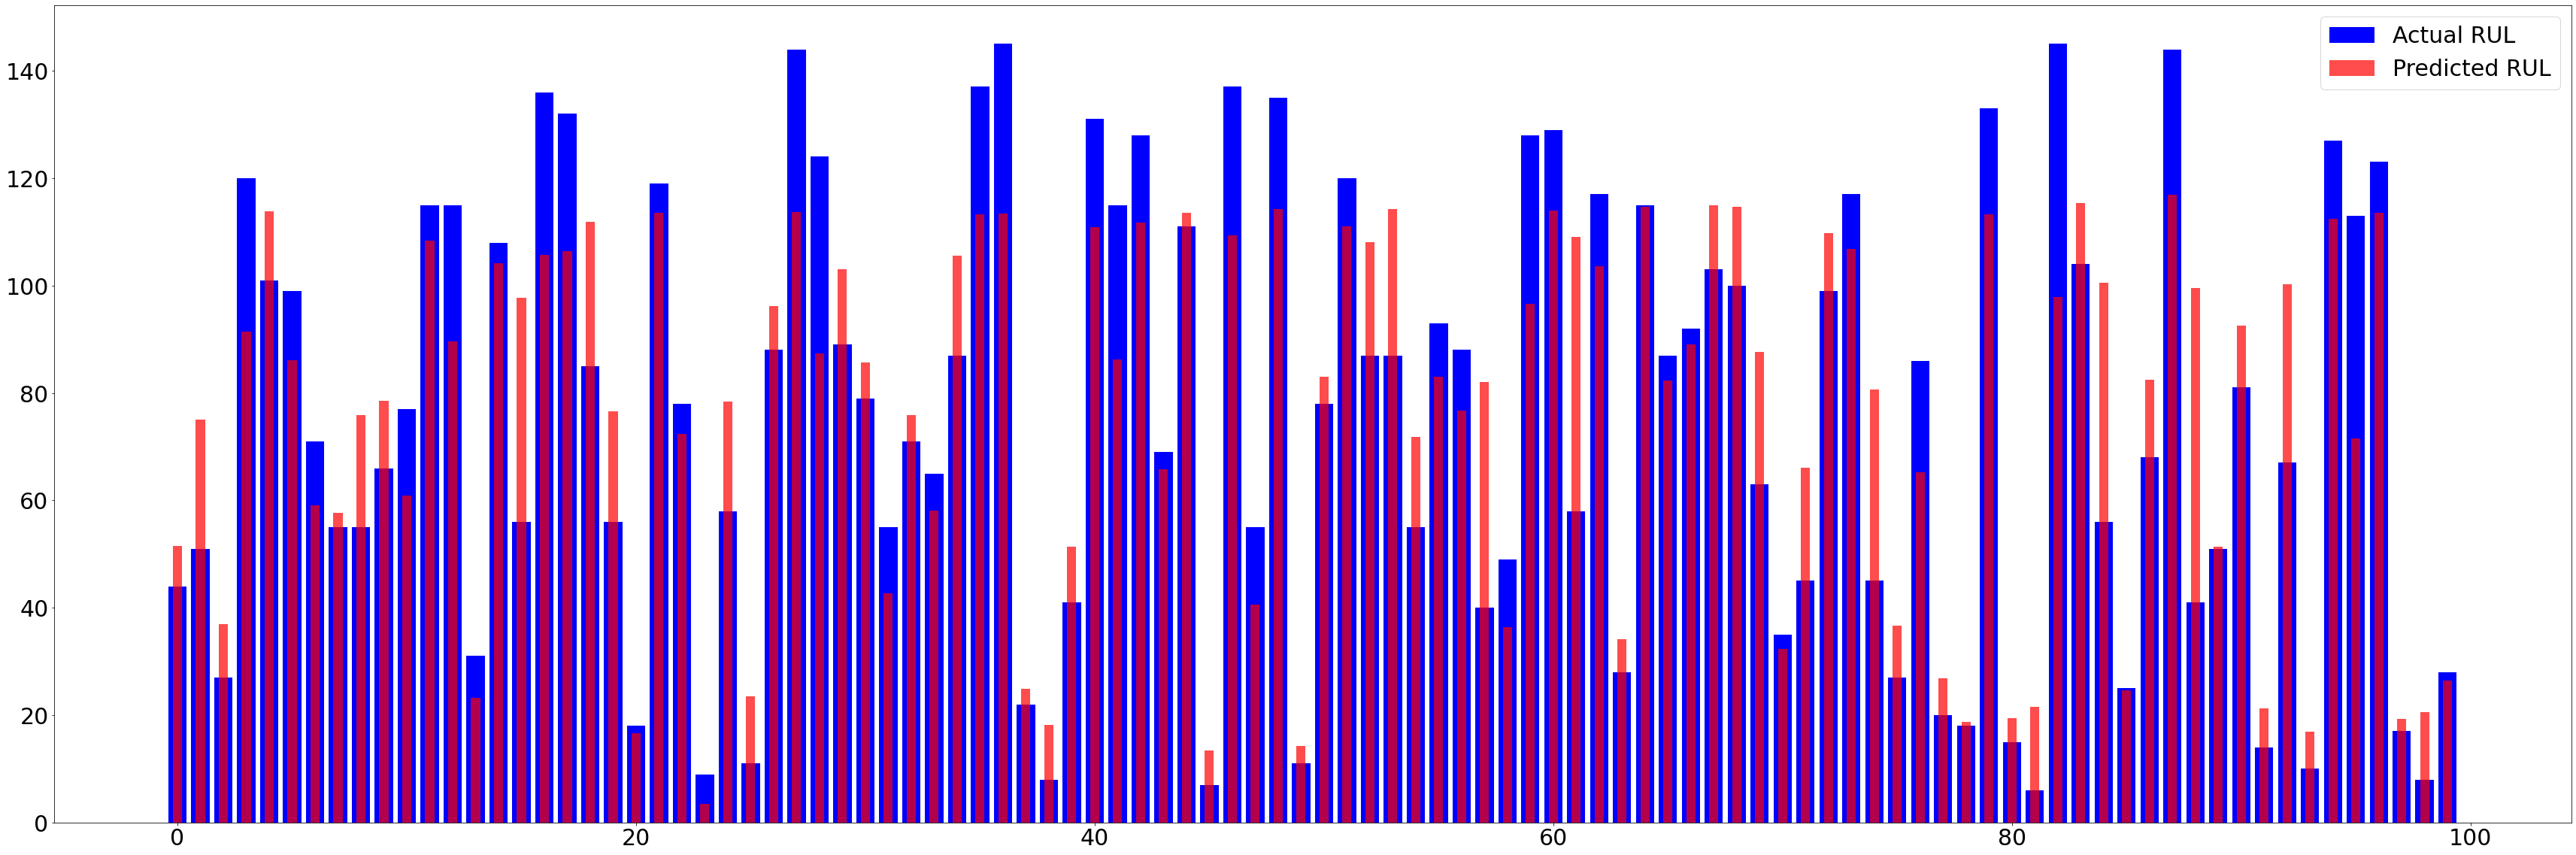

In [ ]:
plot_results(y_test, y_hat_test_catb_clip)

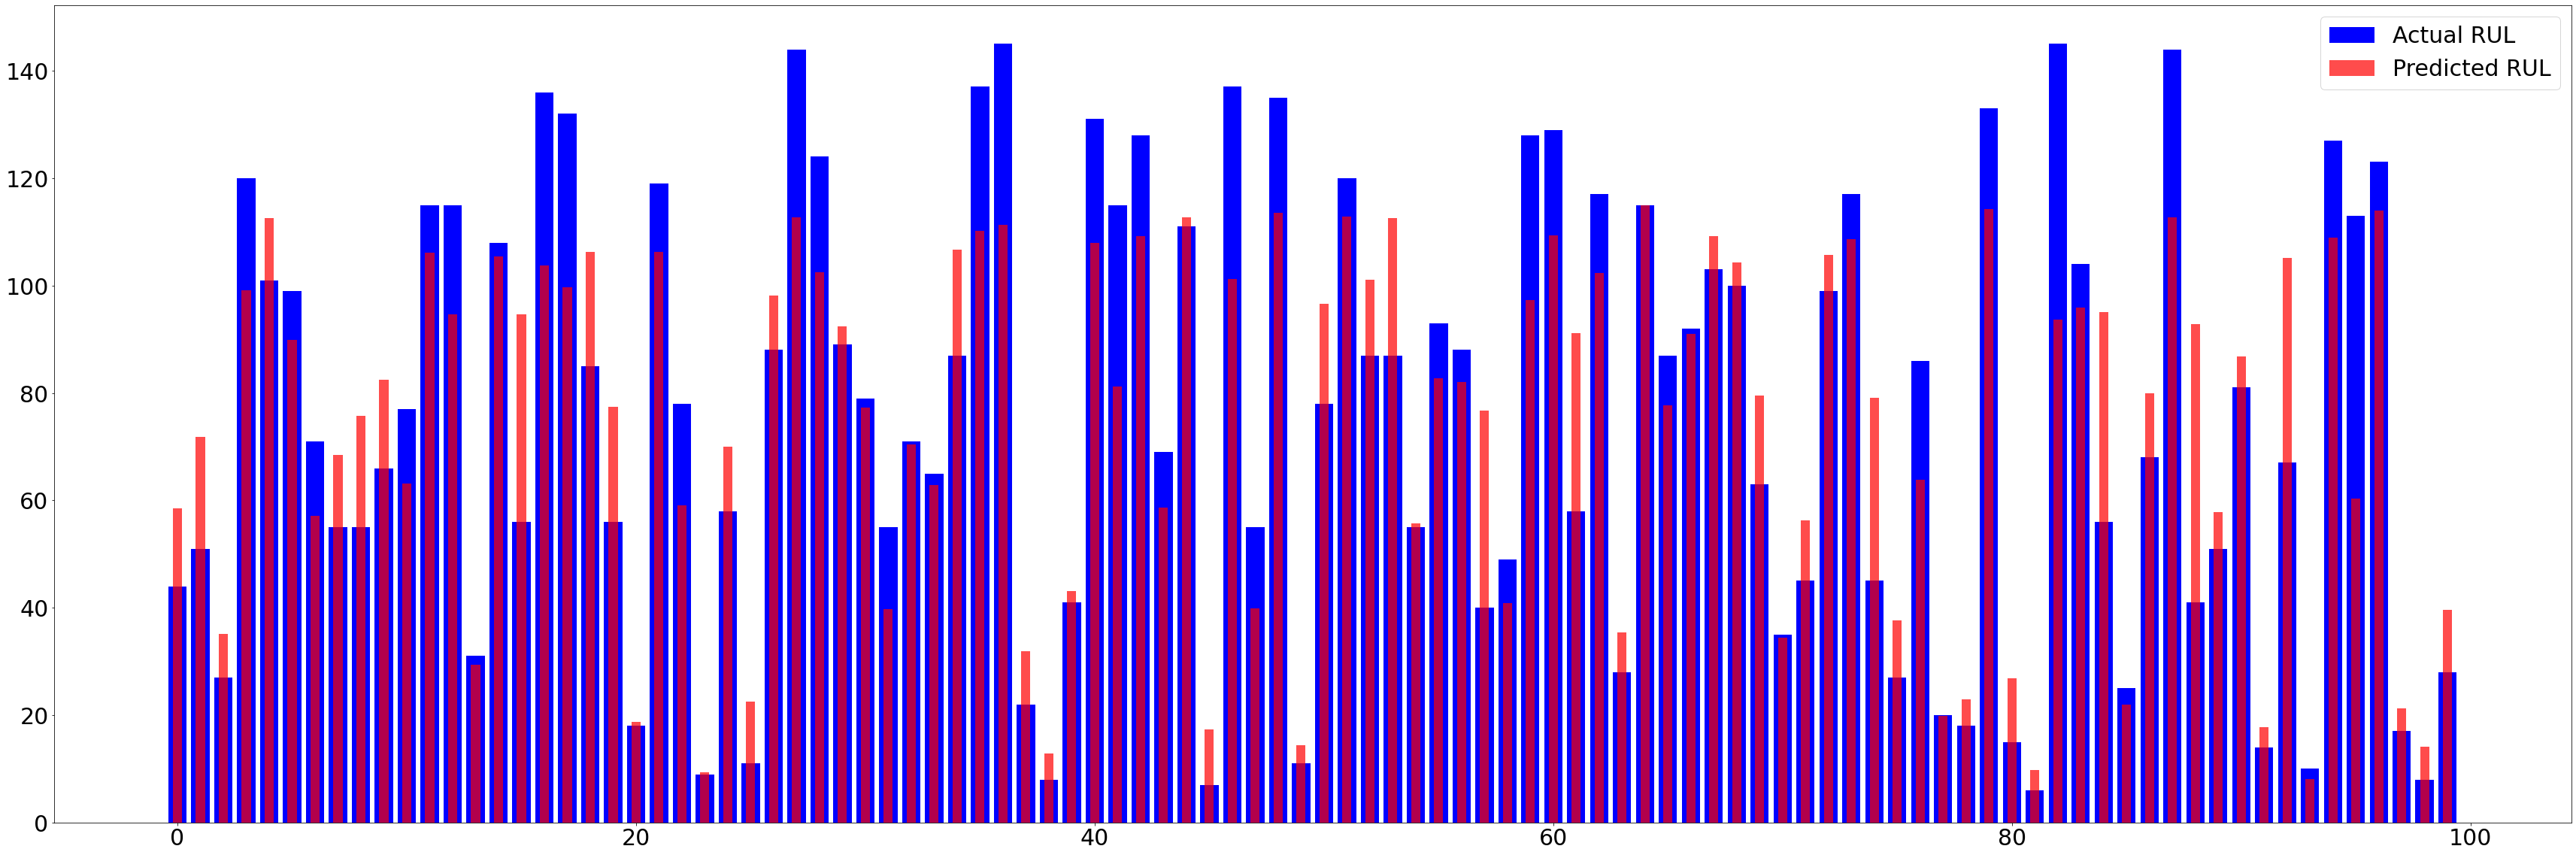

In [ ]:
plot_results(y_test, y_hat_test_rf_clip)

# Поиск гипер-параметров с помощью optuna 

In [ ]:
def objective(trial):
  param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }

  xgb = xgboost.XGBRegressor(**param)
  xgb.fit(X_train, y_train_clipped, verbose=False)

  preds = xgb.predict(X_test)

  mse = mean_squared_error(y_test, preds)
  rmse = np.sqrt(mse)

  return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

[I 2022-11-10 13:41:11,154] A new study created in memory with name: no-name-bce6f1d1-0a81-4b59-9a14-6ac63e84fc55
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd from sys.path.


[13:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-11-10 13:48:03,855] Trial 0 finished with value: 21.11046054409882 and parameters: {'lambda': 0.0956516416576935, 'alpha': 0.9937904895572978, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.018, 'max_depth': 7, 'random_state': 42, 'min_child_weight': 101}. Best is trial 0 with value: 21.11046054409882.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd fr

[13:48:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-11-10 13:51:50,796] Trial 1 finished with value: 20.462717896544255 and parameters: {'lambda': 0.0265233082233989, 'alpha': 0.11230380859634569, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 7, 'random_state': 42, 'min_child_weight': 175}. Best is trial 1 with value: 20.462717896544255.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the cwd 

[13:51:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-11-10 14:02:16,759] Trial 2 finished with value: 21.110061562063084 and parameters: {'lambda': 0.001865166088330474, 'alpha': 0.055268466626915785, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 9, 'random_state': 42, 'min_child_weight': 62}. Best is trial 1 with value: 20.462717896544255.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the c

[14:02:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-11-10 14:11:08,802] Trial 3 finished with value: 19.459850506226157 and parameters: {'lambda': 0.0062293401898326954, 'alpha': 0.7906427531040607, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 11, 'random_state': 42, 'min_child_weight': 43}. Best is trial 3 with value: 19.459850506226157.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  after removing the c

[14:11:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-11-10 14:20:07,681] Trial 4 finished with value: 21.505016413730242 and parameters: {'lambda': 0.057433401474451924, 'alpha': 5.091254610812469, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 13, 'random_state': 42, 'min_child_weight': 203}. Best is trial 3 with value: 19.459850506226157.


In [ ]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 5
Best trial: {'lambda': 0.0062293401898326954, 'alpha': 0.7906427531040607, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 11, 'random_state': 42, 'min_child_weight': 43}


In [ ]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_random_state,params_subsample,state
0,0,21.110461,2022-11-10 13:41:11.160512,2022-11-10 13:48:03.854826,0 days 00:06:52.694314,0.993790,0.7,0.095652,0.018,7,101,42,0.5,COMPLETE
1,1,20.462718,2022-11-10 13:48:03.857719,2022-11-10 13:51:50.795705,0 days 00:03:46.937986,0.112304,0.3,0.026523,0.020,7,175,42,0.7,COMPLETE
2,2,21.110062,2022-11-10 13:51:50.803317,2022-11-10 14:02:16.759140,0 days 00:10:25.955823,0.055268,1.0,0.001865,0.008,9,62,42,0.4,COMPLETE
3,3,19.459851,2022-11-10 14:02:16.762686,2022-11-10 14:11:08.801610,0 days 00:08:52.038924,0.790643,0.5,0.006229,0.018,11,43,42,1.0,COMPLETE
4,4,21.505016,2022-11-10 14:11:08.805020,2022-11-10 14:20:07.681145,0 days 00:08:58.876125,5.091255,0.8,0.057433,0.010,13,203,42,0.4,COMPLETE


In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
Best_trial = study.best_trial.params
Best_trial["n_estimators"] = 10000
Best_trial

{'lambda': 0.0062293401898326954,
 'alpha': 0.7906427531040607,
 'colsample_bytree': 0.5,
 'subsample': 1.0,
 'learning_rate': 0.018,
 'max_depth': 11,
 'random_state': 42,
 'min_child_weight': 43,
 'n_estimators': 10000}

In [ ]:
model = xgboost.XGBRegressor(**Best_trial)
model.fit(X_train, y_train_clipped, verbose=False)

preds = model.predict(X_test)

[14:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
19.459850506226157


In [ ]:
evaluate(y_test, preds)

test set RMSE:19.459850506226157, R2:0.7790112557786786


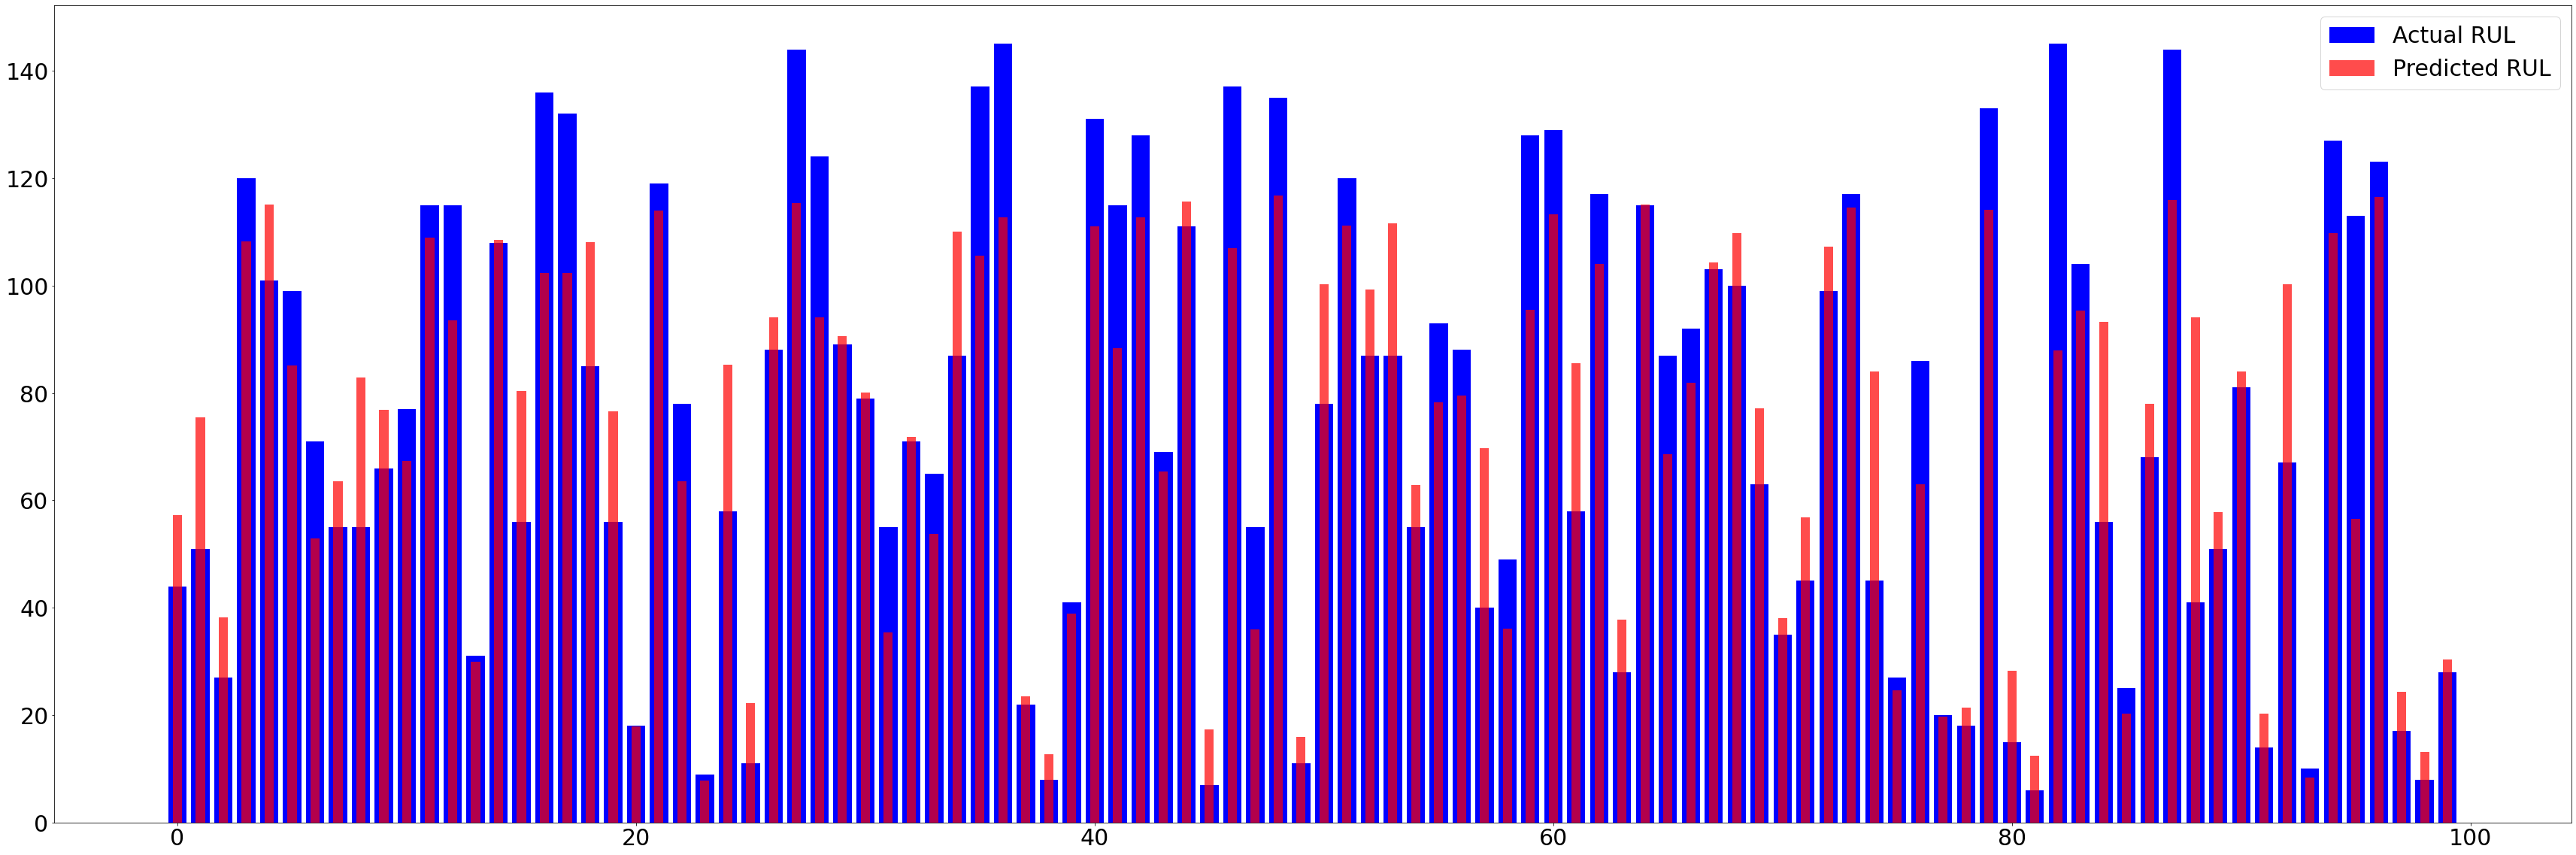

In [ ]:
plot_results(y_test, preds)